In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Function to create windows (as you provided)
def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

# Load your dataset
dataset = pd.read_csv('clean.csv')

# Extract windows and labels from the provided data
X, y = create_windows(dataset.values, window_size=50, step_size=1)

# Convert labels to one-hot encoding for compatibility with the CNN model
y_onehot = to_categorical(y)

# Initialize list to store accuracy for each window when it's used as a validation set
leave_one_out_accuracies = []

for i in range(len(X)):
    # Exclude the i-th window for validation and use all other windows for training
    X_train = np.vstack([X[:i], X[i+1:]])
    y_train = np.vstack([y_onehot[:i], y_onehot[i+1:]])
    
    X_val = np.expand_dims(X[i], axis=0)
    y_val = np.expand_dims(y_onehot[i], axis=0)
    
    # Define the model (same structure as provided)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Validate the model on the excluded window
    _, acc = model.evaluate(X_val, y_val, verbose=0)
    
    leave_one_out_accuracies.append(acc)

# Calculate average accuracy over all windows
average_accuracy = np.mean(leave_one_out_accuracies)
print(f"Average Leave-One-Out Accuracy: {average_accuracy:.4f}")


ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 50, 7)

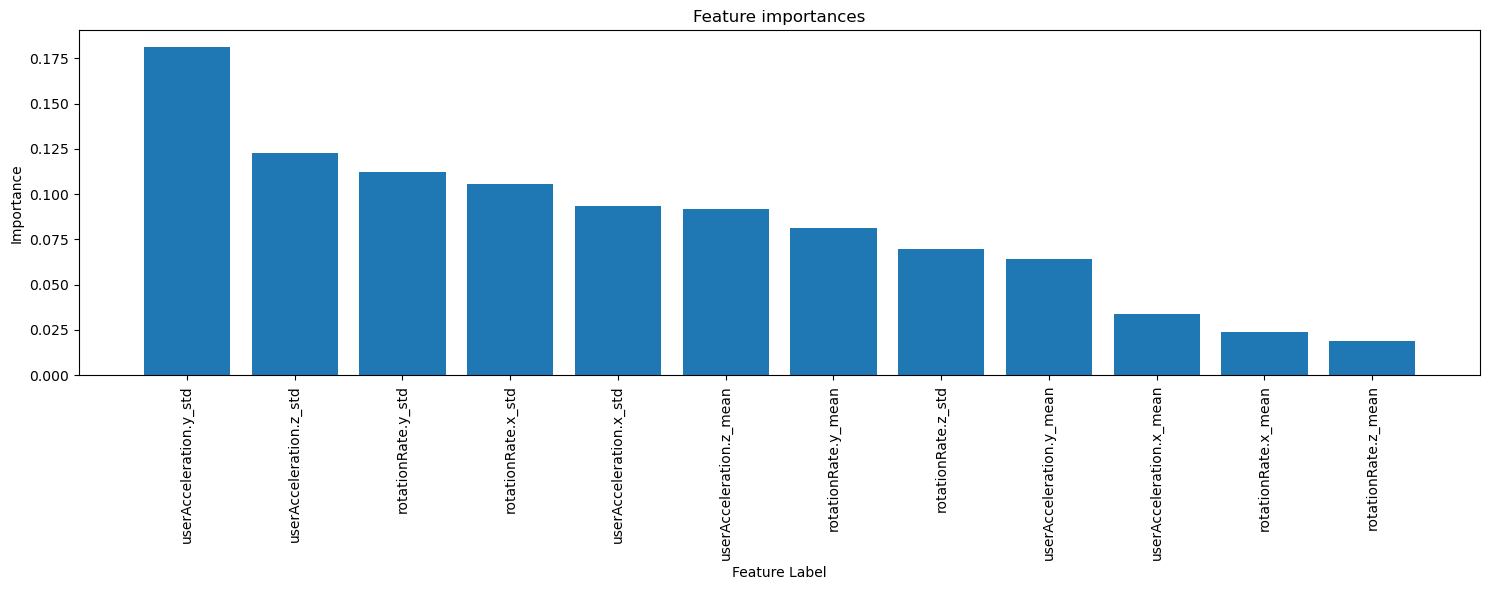

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels, features = [], [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        
        # Calculate features for each window
        mean = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        feature_vector = np.concatenate([mean, std])
        features.append(feature_vector)
        
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels), np.array(features)

def feature_importance_analysis(file_path, window_size=50, step_size=1, target='act'):
    dataset = pd.read_csv(file_path)
    
    # Extract the original feature names
    original_features = dataset.drop(columns=[target, 'id']).columns
    
    # Generate labels for the mean and std of each original feature
    feature_labels = [f"{feature}_mean" for feature in original_features] + [f"{feature}_std" for feature in original_features]

    data_with_labels = np.c_[dataset.drop(columns=[target, 'id']).values, 
                             pd.factorize(dataset[target])[0]]

    _, y, X = create_windows(data_with_labels, window_size, step_size)
    
    # Train Random Forest Classifier
    model = RandomForestClassifier()
    model.fit(X, y)
    
    # Get feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances
    plt.figure(figsize=(15, 6))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    
    # Use the feature labels for x-axis ticks instead of indices
    plt.xticks(range(X.shape[1]), [feature_labels[i] for i in indices], rotation=90)
    
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Importance')
    plt.xlabel('Feature Label')
    plt.tight_layout()
    plt.show()

# Example usage:
file_path = 'clean.csv'
feature_importance_analysis(file_path, window_size=50, step_size=1, target='act')


Epoch 1/10
28257/28257 [==============================] - 74s 3ms/step - loss: 0.8881 - accuracy: 0.6748 - val_loss: 0.7734 - val_accuracy: 0.7208
Epoch 2/10
28257/28257 [==============================] - 70s 2ms/step - loss: 0.7550 - accuracy: 0.7267 - val_loss: 0.7282 - val_accuracy: 0.7371
Epoch 3/10
28257/28257 [==============================] - 71s 3ms/step - loss: 0.7223 - accuracy: 0.7389 - val_loss: 0.7058 - val_accuracy: 0.7433
Epoch 4/10
28257/28257 [==============================] - 72s 3ms/step - loss: 0.7022 - accuracy: 0.7461 - val_loss: 0.6891 - val_accuracy: 0.7503
Epoch 5/10
28257/28257 [==============================] - 86s 3ms/step - loss: 0.6894 - accuracy: 0.7502 - val_loss: 0.6771 - val_accuracy: 0.7551
Epoch 6/10
28257/28257 [==============================] - 82s 3ms/step - loss: 0.6791 - accuracy: 0.7537 - val_loss: 0.6628 - val_accuracy: 0.7604
Epoch 7/10
28257/28257 [==============================] - 82s 3ms/step - loss: 0.6713 - accuracy: 0.7565 - val_loss: 0

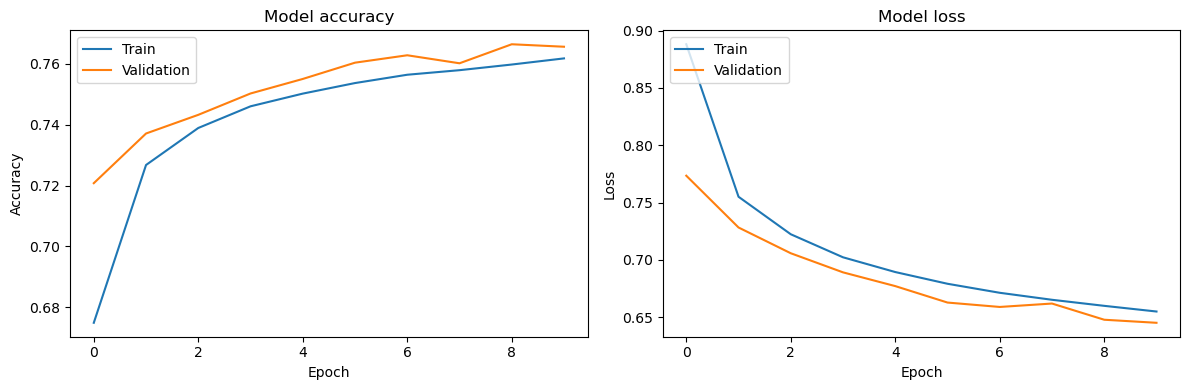

35321/35321 [==============================] - 20s 572us/step


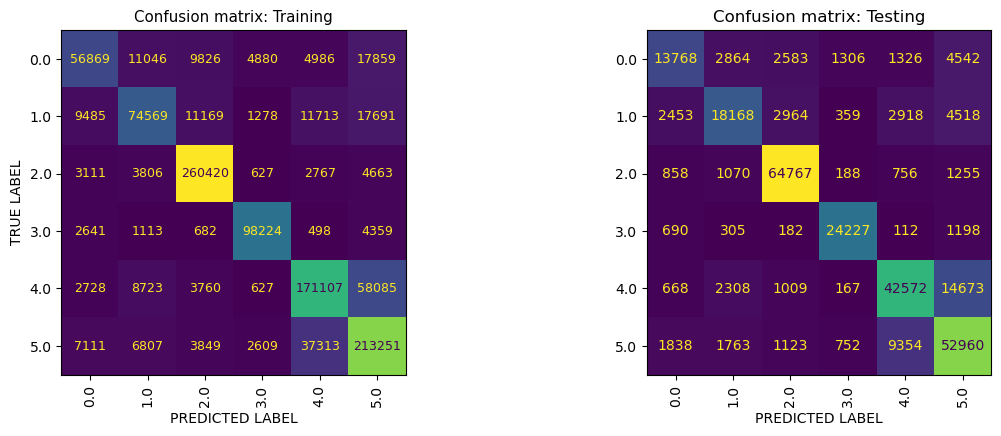

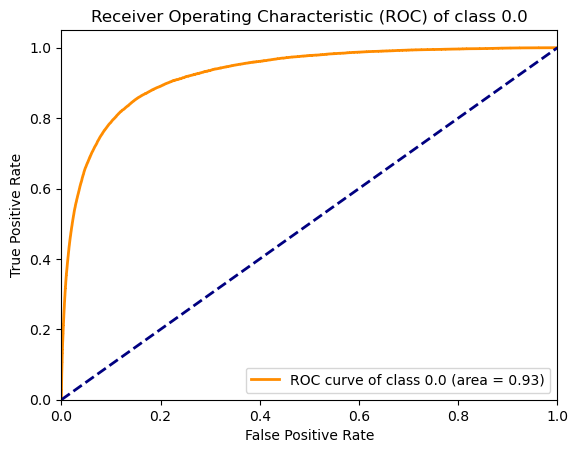

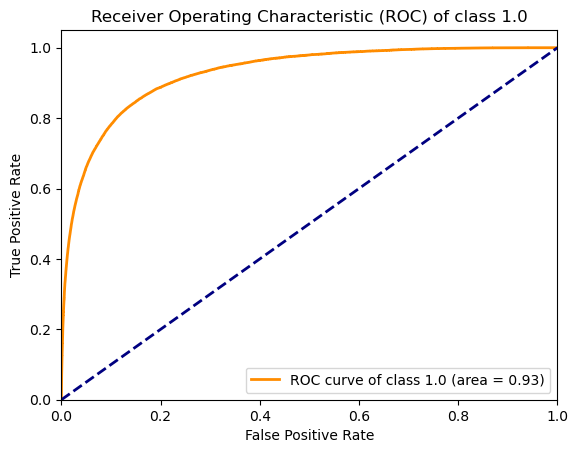

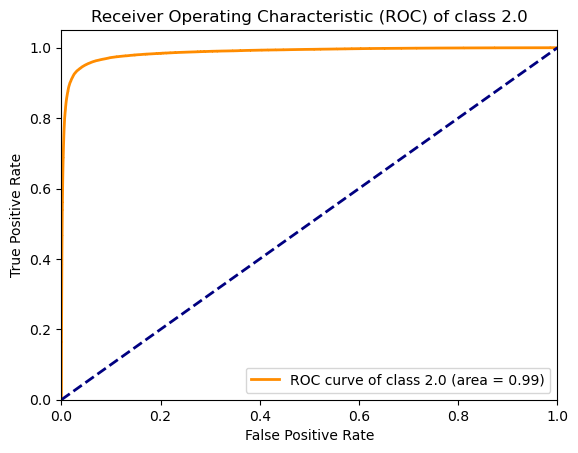

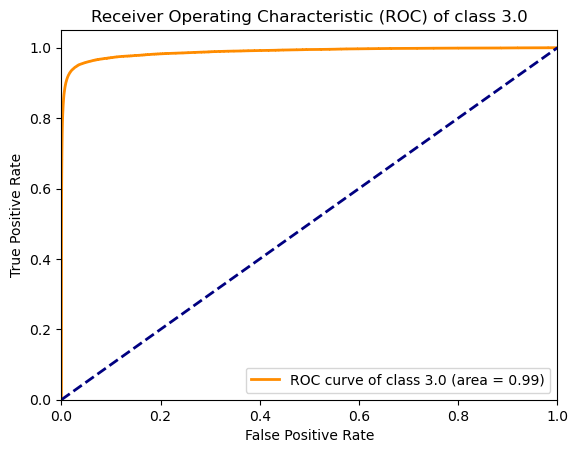

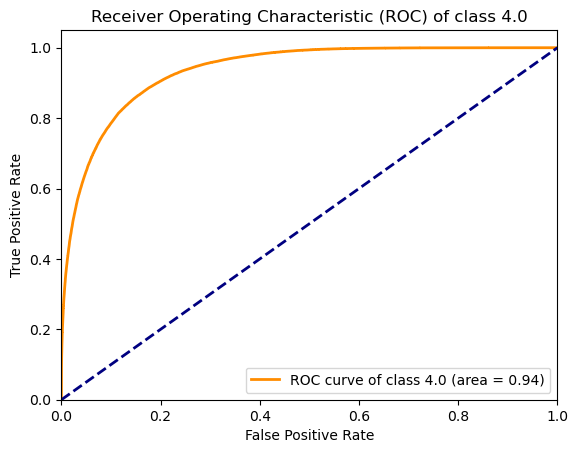

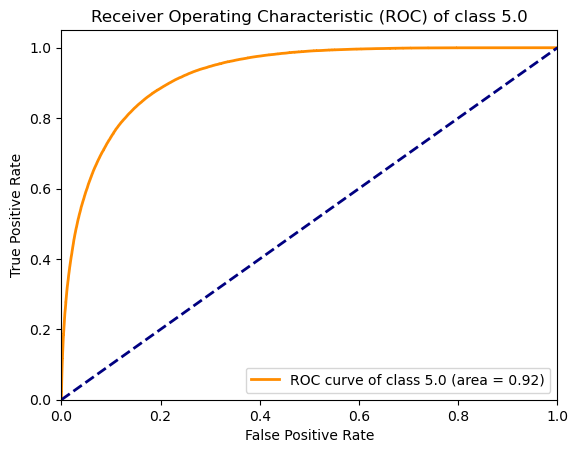

Accuracy: 0.7660636174459592
Confusion Matrix: 
[[13768  2864  2583  1306  1326  4542]
 [ 2453 18168  2964   359  2918  4518]
 [  858  1070 64767   188   756  1255]
 [  690   305   182 24227   112  1198]
 [  668  2308  1009   167 42572 14673]
 [ 1838  1763  1123   752  9354 52960]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.52      0.59     26389
           1       0.69      0.58      0.63     31380
           2       0.89      0.94      0.92     68894
           3       0.90      0.91      0.90     26714
           4       0.75      0.69      0.72     61397
           5       0.67      0.78      0.72     67790

    accuracy                           0.77    282564
   macro avg       0.76      0.74      0.75    282564
weighted avg       0.76      0.77      0.76    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [3]:
# 删掉了那两列数据后的模型准确率
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_dropped.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


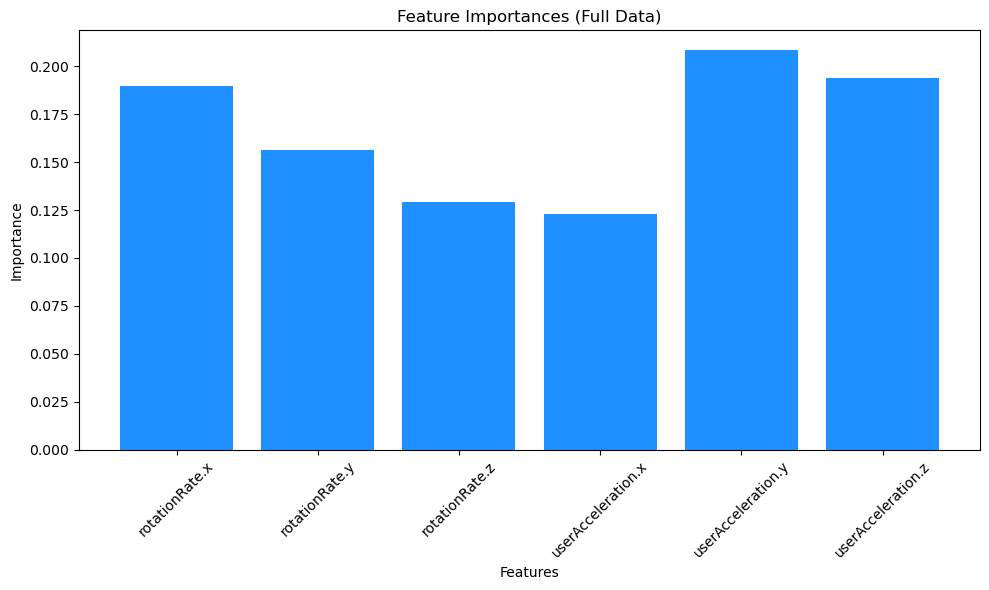

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Loading the entire dataset
data_full = pd.read_csv('clean.csv')

# Specifying the features and the target variable
features = [
    "rotationRate.x", "rotationRate.y", "rotationRate.z",
    "userAcceleration.x", "userAcceleration.y", "userAcceleration.z"
]
target = "act"

# Training the Random Forest classifier on the entire data
clf_full_data = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full_data.fit(data_full[features], data_full[target])

# Getting feature importances from the model trained on full data
feature_importances_full = clf_full_data.feature_importances_

# Visualizing the feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances_full, color='dodgerblue')
plt.title('Feature Importances (Full Data)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/10
28257/28257 [==============================] - 98s 3ms/step - loss: 0.2996 - accuracy: 0.9023 - val_loss: 0.2051 - val_accuracy: 0.9344
Epoch 2/10
28257/28257 [==============================] - 96s 3ms/step - loss: 0.2042 - accuracy: 0.9333 - val_loss: 0.1706 - val_accuracy: 0.9442
Epoch 3/10
28257/28257 [==============================] - 96s 3ms/step - loss: 0.1767 - accuracy: 0.9415 - val_loss: 0.1632 - val_accuracy: 0.9469
Epoch 4/10
28257/28257 [==============================] - 95s 3ms/step - loss: 0.1603 - accuracy: 0.9467 - val_loss: 0.1488 - val_accuracy: 0.9515
Epoch 5/10
28257/28257 [==============================] - 102s 4ms/step - loss: 0.1489 - accuracy: 0.9500 - val_loss: 0.1458 - val_accuracy: 0.9524
Epoch 6/10
28257/28257 [==============================] - 98s 3ms/step - loss: 0.1399 - accuracy: 0.9527 - val_loss: 0.1408 - val_accuracy: 0.9541
Epoch 7/10
28257/28257 [==============================] - 97s 3ms/step - loss: 0.1330 - accuracy: 0.9548 - val_loss: 

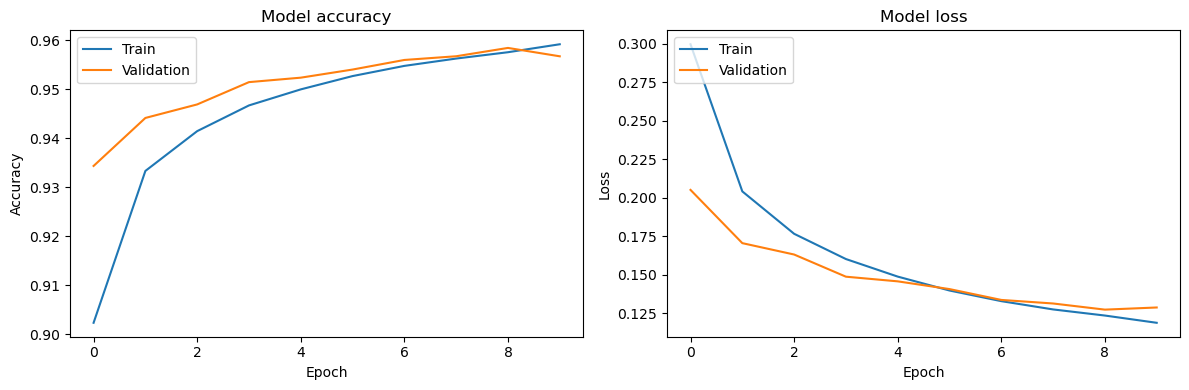

35321/35321 [==============================] - 29s 809us/step


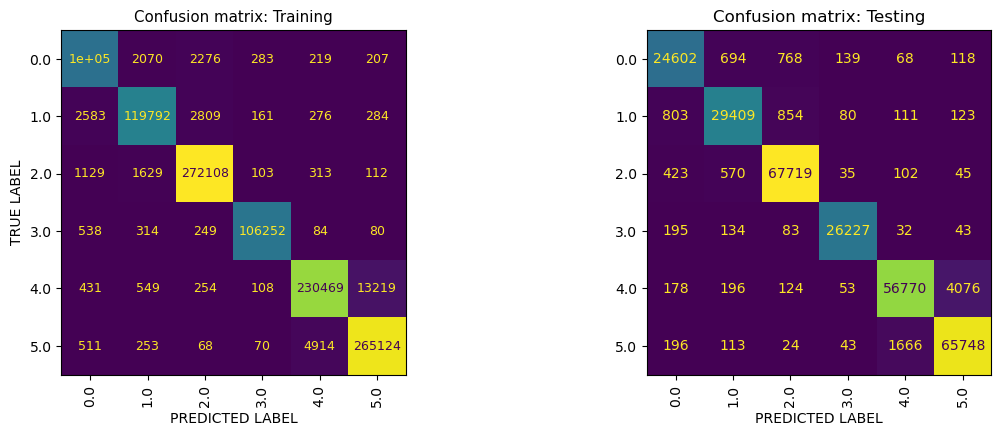

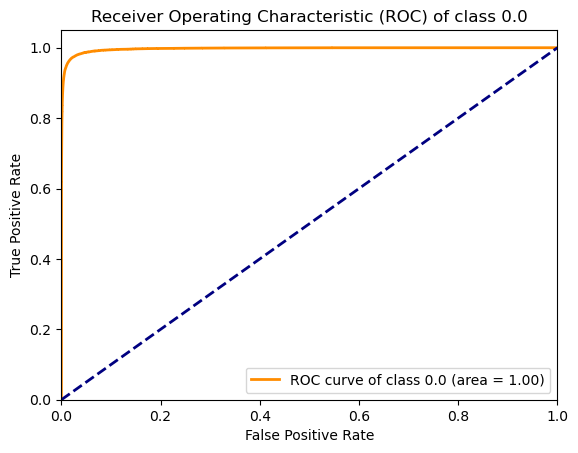

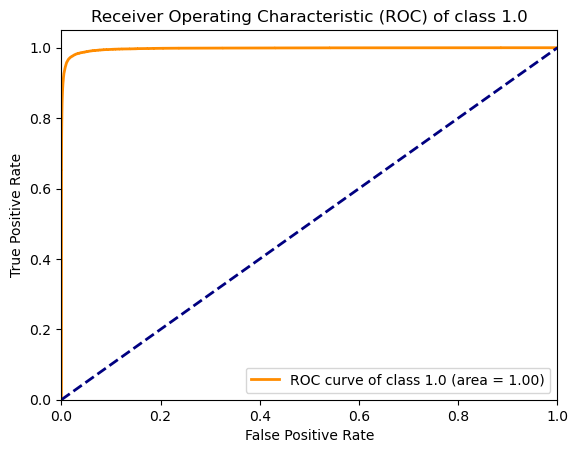

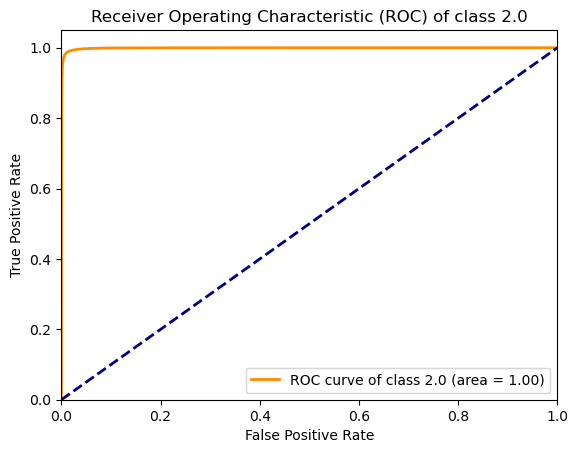

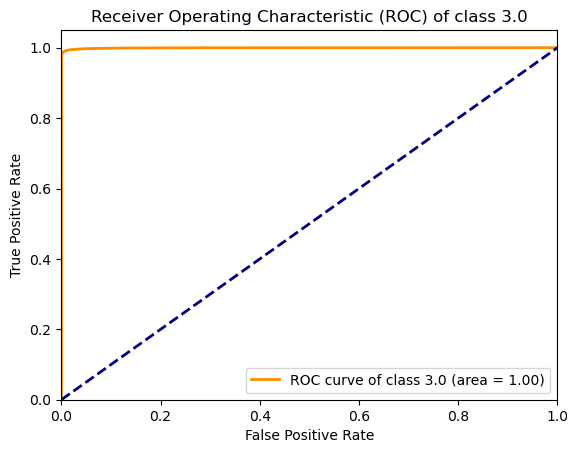

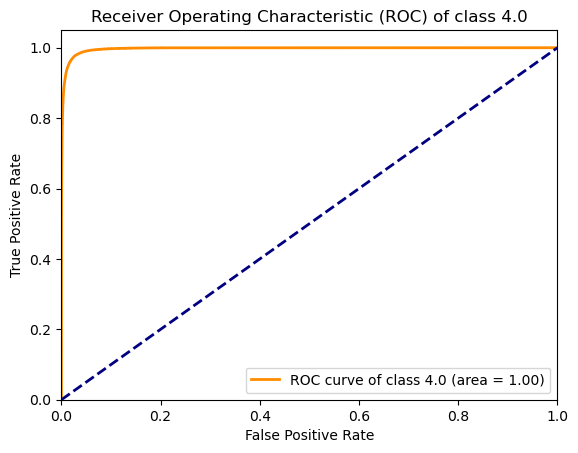

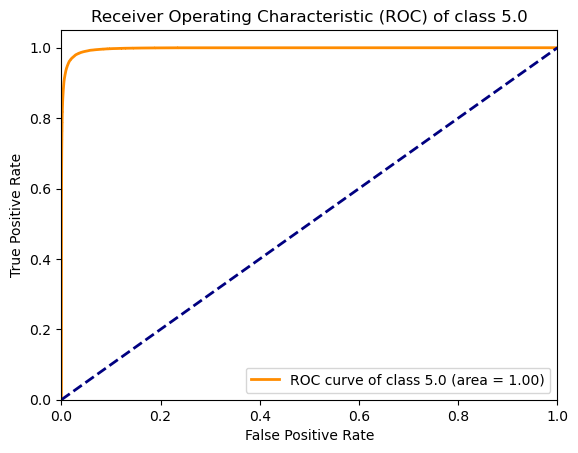

Accuracy: 0.9572167721294998
Confusion Matrix: 
[[24602   694   768   139    68   118]
 [  803 29409   854    80   111   123]
 [  423   570 67719    35   102    45]
 [  195   134    83 26227    32    43]
 [  178   196   124    53 56770  4076]
 [  196   113    24    43  1666 65748]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     26389
           1       0.95      0.94      0.94     31380
           2       0.97      0.98      0.98     68894
           3       0.99      0.98      0.98     26714
           4       0.97      0.92      0.95     61397
           5       0.94      0.97      0.95     67790

    accuracy                           0.96    282564
   macro avg       0.96      0.95      0.96    282564
weighted avg       0.96      0.96      0.96    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_reduced.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
28257/28257 [==============================] - 97s 3ms/step - loss: 0.2750 - accuracy: 0.9109 - val_loss: 0.1769 - val_accuracy: 0.9442
Epoch 2/10
28257/28257 [==============================] - 94s 3ms/step - loss: 0.1789 - accuracy: 0.9427 - val_loss: 0.1458 - val_accuracy: 0.9535
Epoch 3/10
28257/28257 [==============================] - 93s 3ms/step - loss: 0.1512 - accuracy: 0.9506 - val_loss: 0.1328 - val_accuracy: 0.9578
Epoch 4/10
28257/28257 [==============================] - 102s 4ms/step - loss: 0.1354 - accuracy: 0.9556 - val_loss: 0.1250 - val_accuracy: 0.9596
Epoch 5/10
28257/28257 [==============================] - 94s 3ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 0.1151 - val_accuracy: 0.9626
Epoch 6/10
28257/28257 [==============================] - 95s 3ms/step - loss: 0.1155 - accuracy: 0.9612 - val_loss: 0.1114 - val_accuracy: 0.9630
Epoch 7/10
28257/28257 [==============================] - 108s 4ms/step - loss: 0.1096 - accuracy: 0.9630 - val_loss:

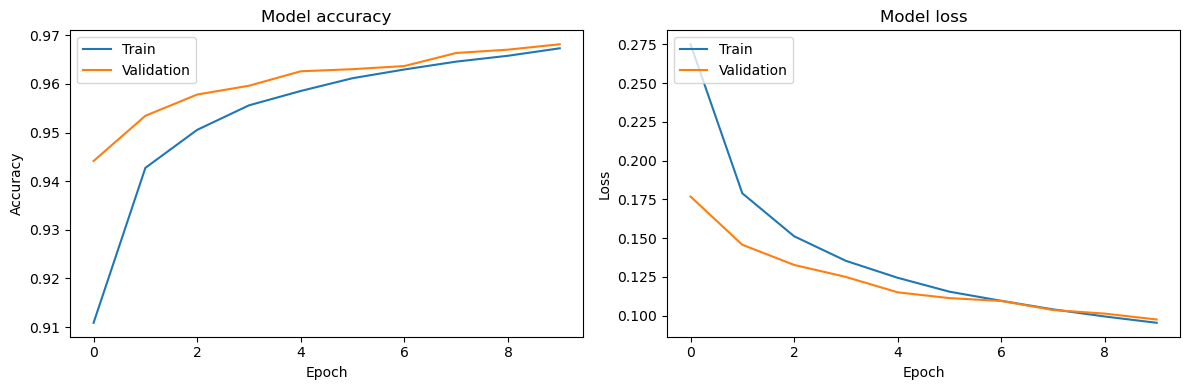

35321/35321 [==============================] - 30s 835us/step


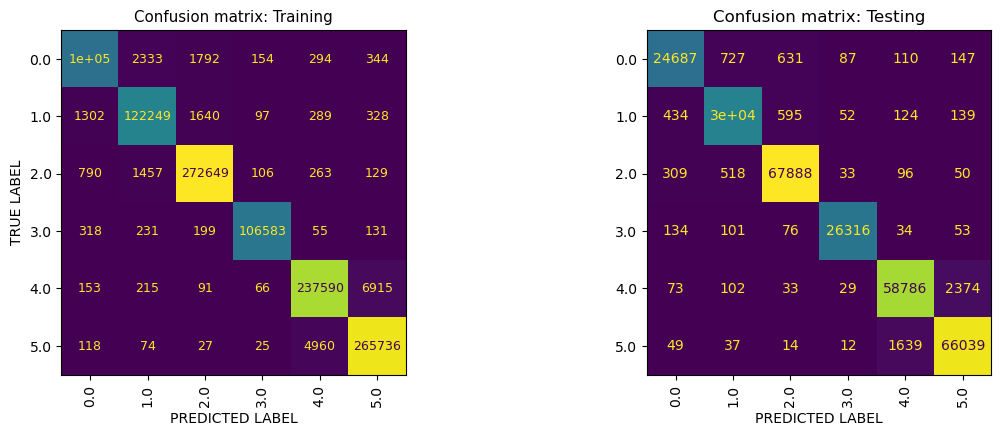

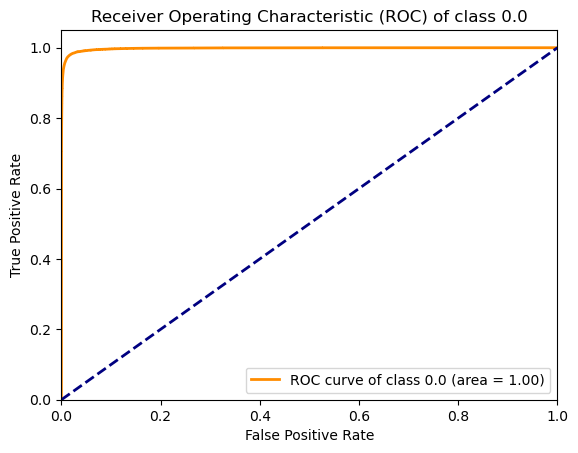

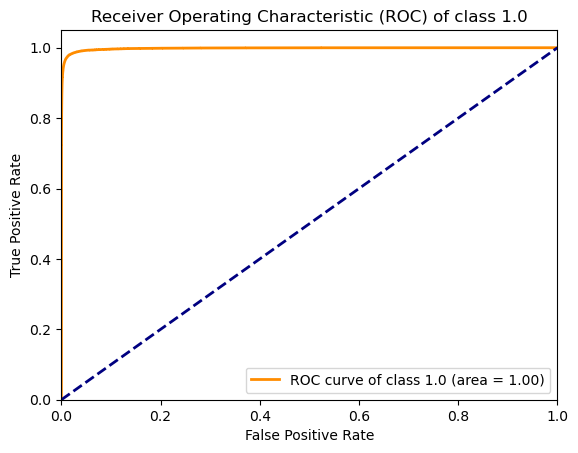

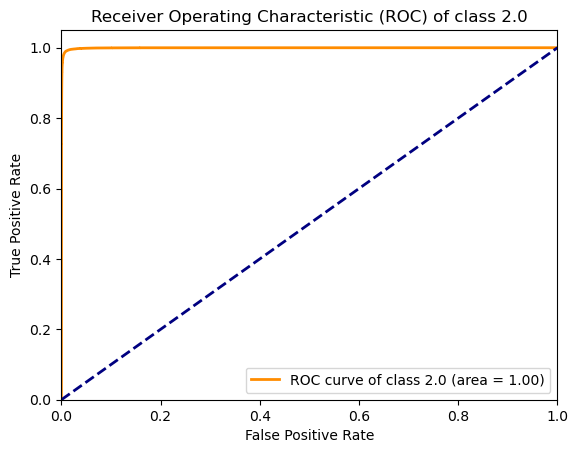

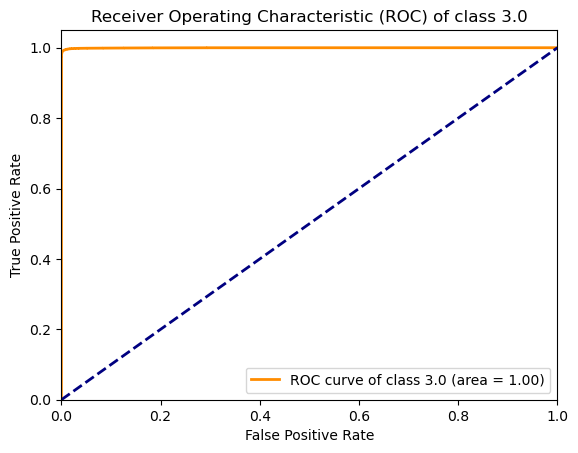

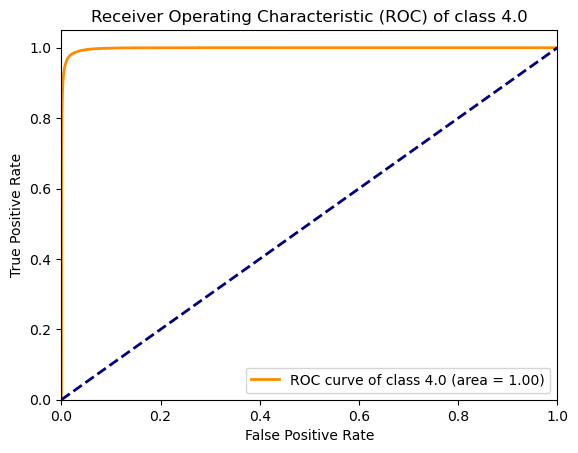

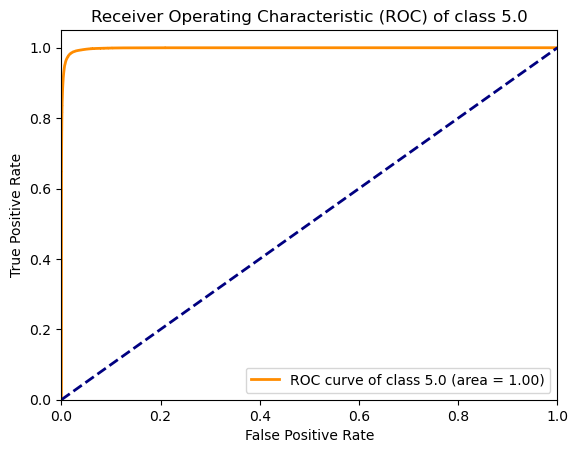

Accuracy: 0.9688141447601252
Confusion Matrix: 
[[24687   727   631    87   110   147]
 [  434 30036   595    52   124   139]
 [  309   518 67888    33    96    50]
 [  134   101    76 26316    34    53]
 [   73   102    33    29 58786  2374]
 [   49    37    14    12  1639 66039]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     26389
           1       0.95      0.96      0.96     31380
           2       0.98      0.99      0.98     68894
           3       0.99      0.99      0.99     26714
           4       0.97      0.96      0.96     61397
           5       0.96      0.97      0.97     67790

    accuracy                           0.97    282564
   macro avg       0.97      0.97      0.97    282564
weighted avg       0.97      0.97      0.97    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_modified.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
27974/27974 [==============================] - 110s 4ms/step - loss: 0.2527 - accuracy: 0.9188 - val_loss: 0.1715 - val_accuracy: 0.9446
Epoch 2/10
27974/27974 [==============================] - 103s 4ms/step - loss: 0.1573 - accuracy: 0.9496 - val_loss: 0.1247 - val_accuracy: 0.9603
Epoch 3/10
27974/27974 [==============================] - 103s 4ms/step - loss: 0.1299 - accuracy: 0.9575 - val_loss: 0.1093 - val_accuracy: 0.9647
Epoch 4/10
27974/27974 [==============================] - 104s 4ms/step - loss: 0.1135 - accuracy: 0.9623 - val_loss: 0.1009 - val_accuracy: 0.9674
Epoch 5/10
27974/27974 [==============================] - 104s 4ms/step - loss: 0.1013 - accuracy: 0.9662 - val_loss: 0.0967 - val_accuracy: 0.9691
Epoch 6/10
27974/27974 [==============================] - 102s 4ms/step - loss: 0.0937 - accuracy: 0.9683 - val_loss: 0.0878 - val_accuracy: 0.9712
Epoch 7/10
27974/27974 [==============================] - 114s 4ms/step - loss: 0.0870 - accuracy: 0.9704 - val_

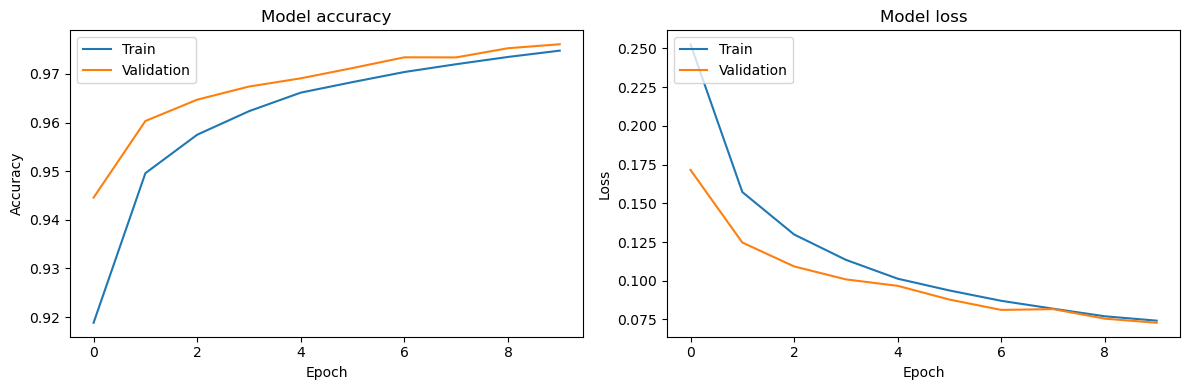

34968/34968 [==============================] - 31s 895us/step


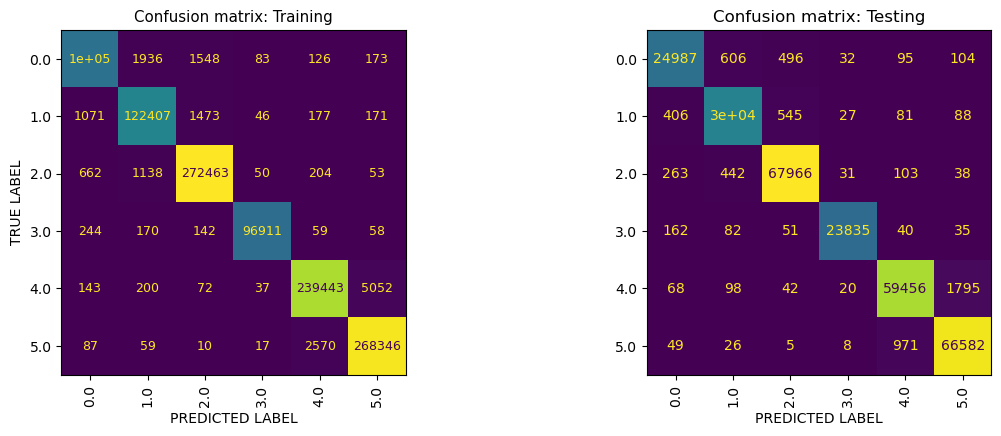

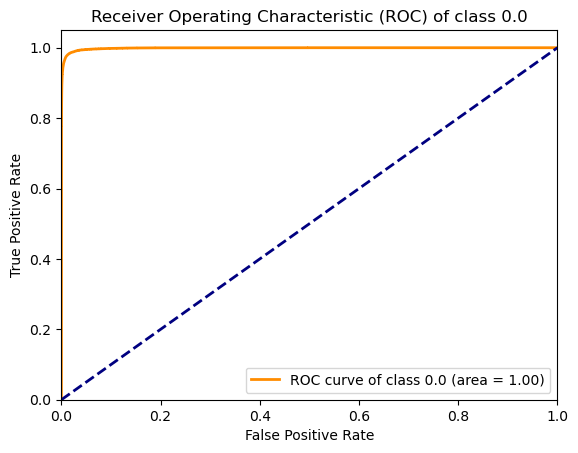

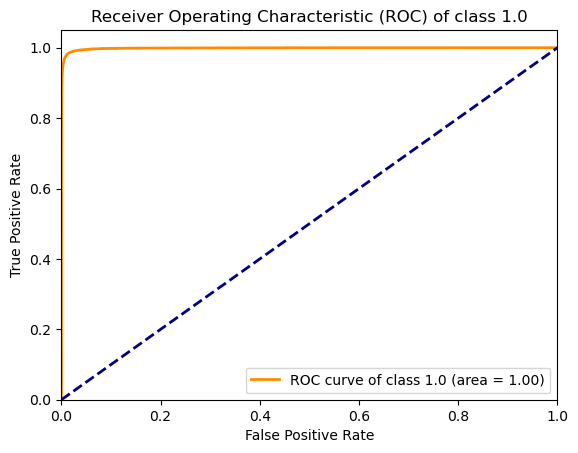

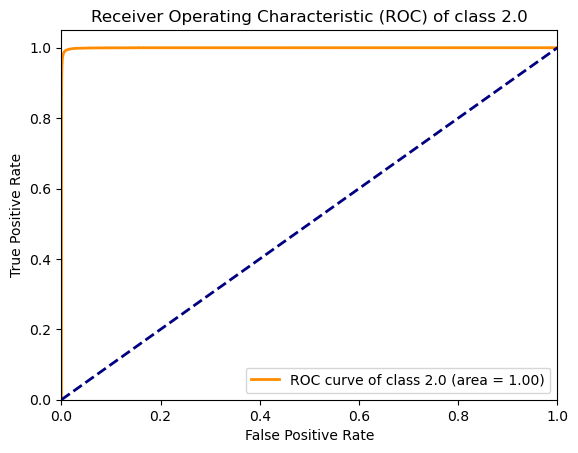

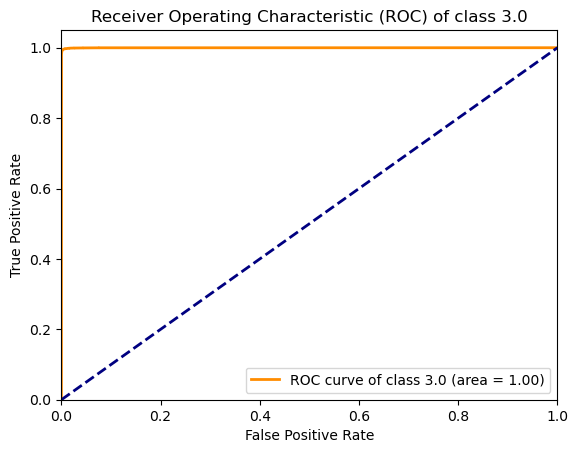

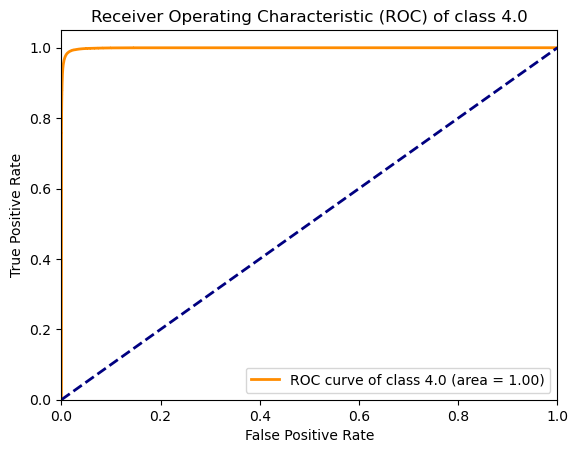

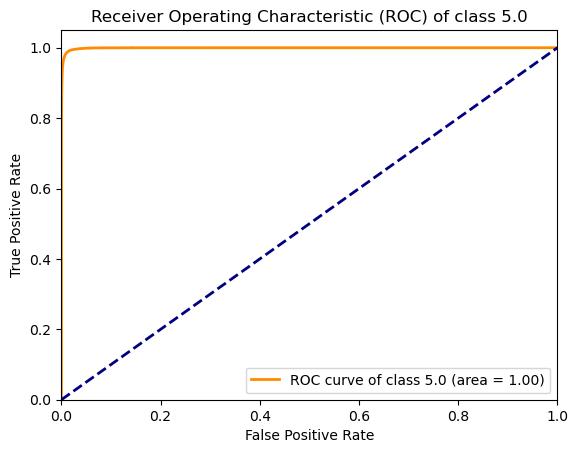

Accuracy: 0.97565927996654
Confusion Matrix: 
[[24987   606   496    32    95   104]
 [  406 30102   545    27    81    88]
 [  263   442 67966    31   103    38]
 [  162    82    51 23835    40    35]
 [   68    98    42    20 59456  1795]
 [   49    26     5     8   971 66582]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     26320
           1       0.96      0.96      0.96     31249
           2       0.98      0.99      0.99     68843
           3       1.00      0.98      0.99     24205
           4       0.98      0.97      0.97     61479
           5       0.97      0.98      0.98     67641

    accuracy                           0.98    279737
   macro avg       0.98      0.97      0.97    279737
weighted avg       0.98      0.98      0.98    279737

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [23]:
#数据存在原始的和滑动平均值
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'cleaned_data.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [22]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Load the data
data_modified = pd.read_csv("clean_modified.csv")

# Apply moving average over a sliding window for each feature column
window_size = 5
for column in ['rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.y', 'userAcceleration.z']:
    data_modified[column + '_moving_avg'] = data_modified[column].rolling(window=window_size).mean()

# Drop rows with NaN values from the moving average calculation
data_no_nan = data_modified.dropna()

# Features for Isolation Forest after applying moving average
features_moving_avg = data_no_nan.drop(columns=['act', 'id', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.y', 'userAcceleration.z'])

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Predict anomalies on the smoothed data
anomalies_moving_avg = iso_forest.fit_predict(features_moving_avg)

# Convert -1 labels (anomalies) to True and 1 labels (normal) to False
anomaly_indices_moving_avg = anomalies_moving_avg == -1

# Drop the rows identified as anomalies
data_cleaned = data_no_nan[~anomaly_indices_moving_avg]

# Save the cleaned data to a CSV file (optional)
data_cleaned.to_csv("cleaned_data.csv", index=False)

# Print the shape of the cleaned data
print(data_cleaned.shape)


(1398732, 12)


In [24]:
# 数据只有滑动平均值
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'filtered_data.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
27974/27974 [==============================] - 161s 6ms/step - loss: 0.3120 - accuracy: 0.8990 - val_loss: 0.1999 - val_accuracy: 0.9367
Epoch 2/10
27974/27974 [==============================] - 116s 4ms/step - loss: 0.1932 - accuracy: 0.9372 - val_loss: 0.1572 - val_accuracy: 0.9497
Epoch 3/10
27974/27974 [==============================] - 118s 4ms/step - loss: 0.1611 - accuracy: 0.9471 - val_loss: 0.1388 - val_accuracy: 0.9556
Epoch 4/10
27974/27974 [==============================] - 113s 4ms/step - loss: 0.1412 - accuracy: 0.9528 - val_loss: 0.1255 - val_accuracy: 0.9597
Epoch 5/10
27962/27974 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9568

KeyboardInterrupt: 

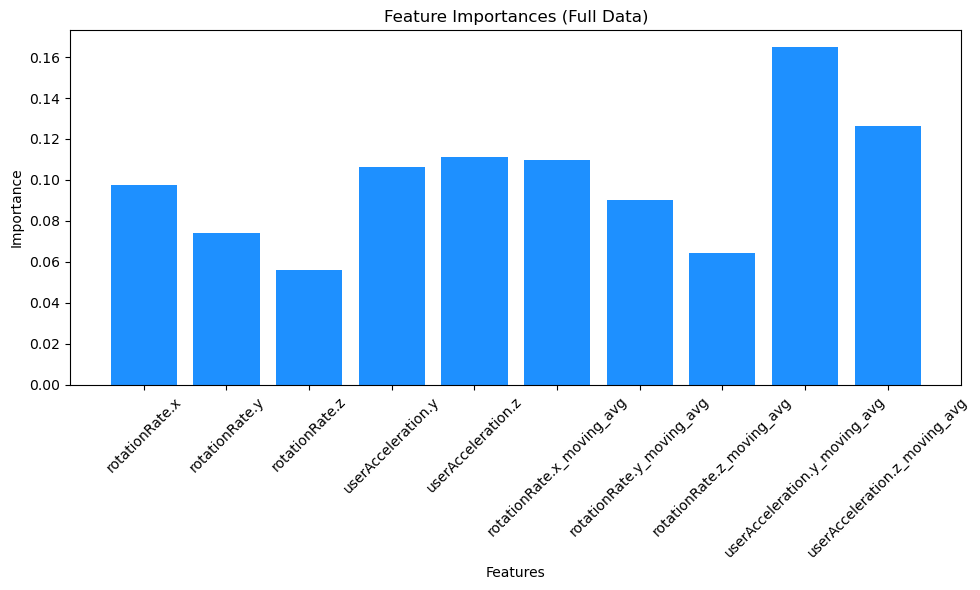

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Loading the entire dataset
data_full = pd.read_csv('cleaned_data.csv')

# Specifying the features and the target variable
features = [
    "rotationRate.x", "rotationRate.y", "rotationRate.z",
    "userAcceleration.y", "userAcceleration.z", "rotationRate.x_moving_avg",
    "rotationRate.y_moving_avg","rotationRate.z_moving_avg","userAcceleration.y_moving_avg",
    "userAcceleration.z_moving_avg"
]
target = "act"

# Training the Random Forest classifier on the entire data
clf_full_data = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full_data.fit(data_full[features], data_full[target])

# Getting feature importances from the model trained on full data
feature_importances_full = clf_full_data.feature_importances_

# Visualizing the feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances_full, color='dodgerblue')
plt.title('Feature Importances (Full Data)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# 数据只有滑动平均值
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'cleaned_data_modified.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
28257/28257 [==============================] - 76s 3ms/step - loss: 1.0380 - accuracy: 0.5703 - val_loss: 0.8546 - val_accuracy: 0.6484
Epoch 2/10
28257/28257 [==============================] - 74s 3ms/step - loss: 0.8622 - accuracy: 0.6428 - val_loss: 0.7787 - val_accuracy: 0.6762
Epoch 3/10
28257/28257 [==============================] - 74s 3ms/step - loss: 0.8042 - accuracy: 0.6674 - val_loss: 0.7482 - val_accuracy: 0.6917
Epoch 4/10
28257/28257 [==============================] - 74s 3ms/step - loss: 0.7699 - accuracy: 0.6820 - val_loss: 0.7241 - val_accuracy: 0.7004
Epoch 5/10
28257/28257 [==============================] - 73s 3ms/step - loss: 0.7475 - accuracy: 0.6909 - val_loss: 0.6999 - val_accuracy: 0.7097
Epoch 6/10
28257/28257 [==============================] - 73s 3ms/step - loss: 0.7311 - accuracy: 0.6981 - val_loss: 0.6873 - val_accuracy: 0.7150
Epoch 7/10
28257/28257 [==============================] - 73s 3ms/step - loss: 0.7177 - accuracy: 0.7032 - val_loss: 0

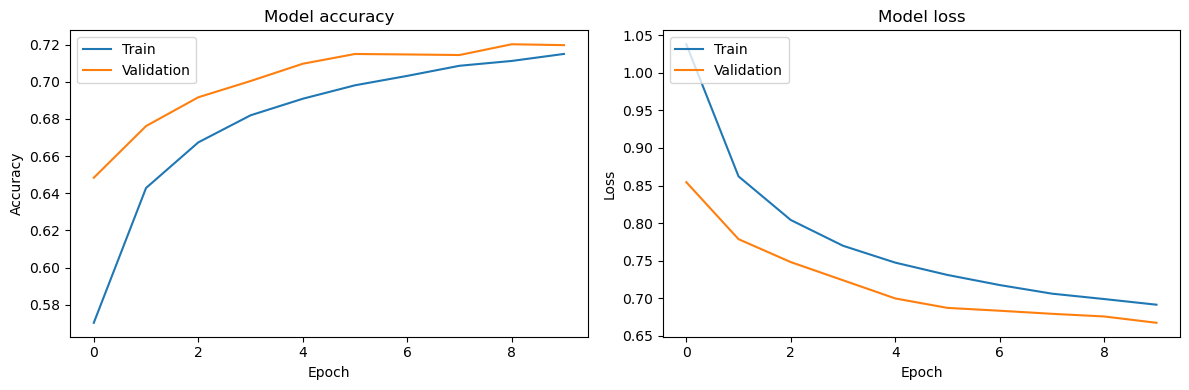

35321/35321 [==============================] - 23s 656us/step


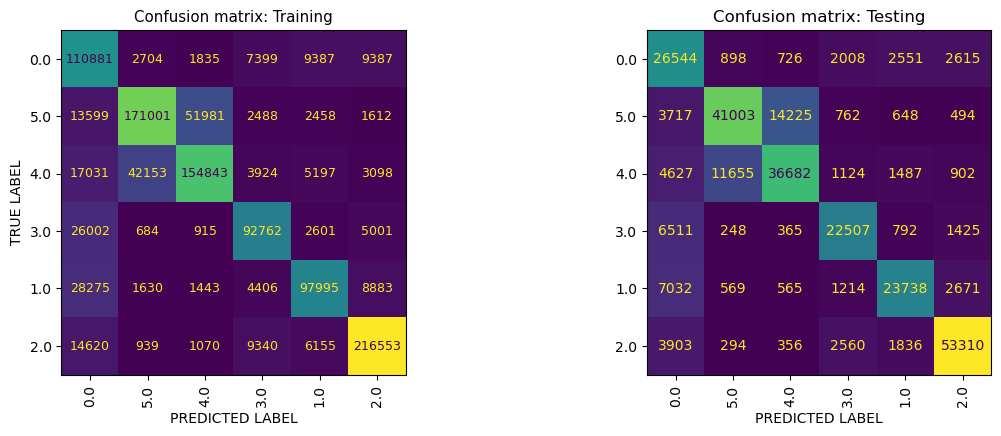

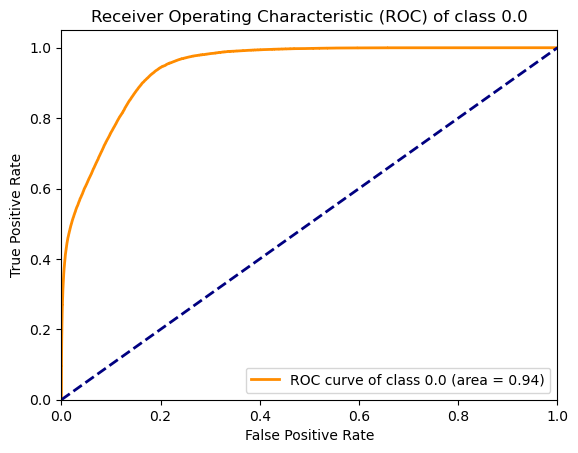

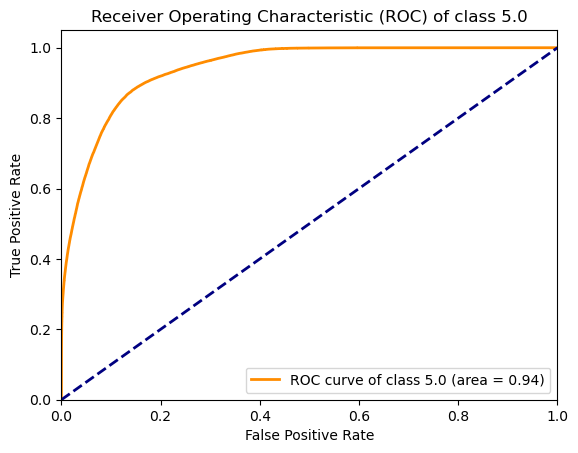

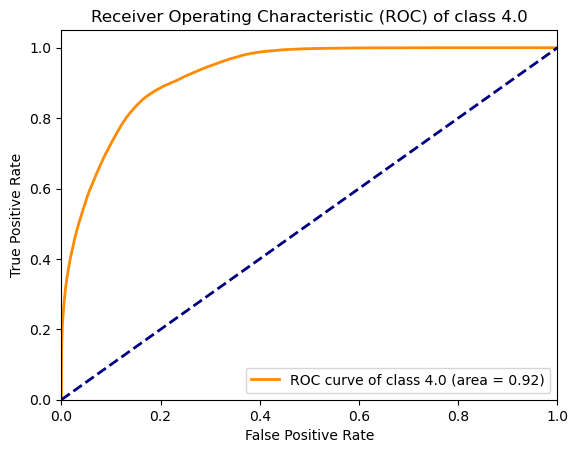

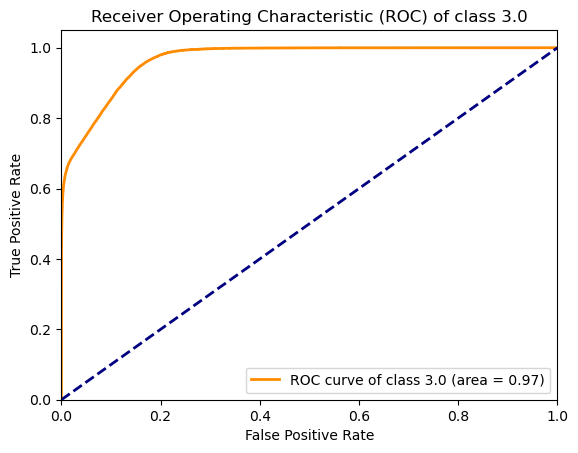

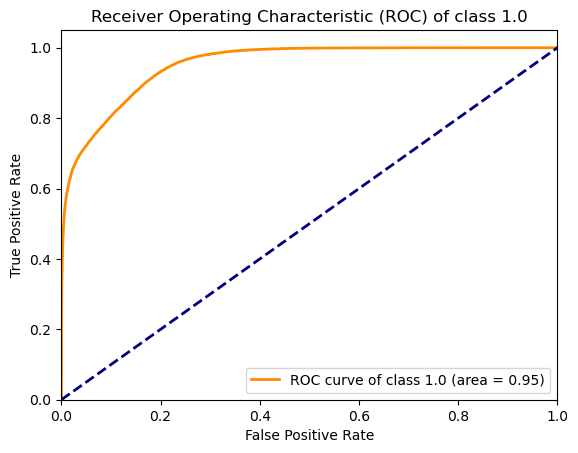

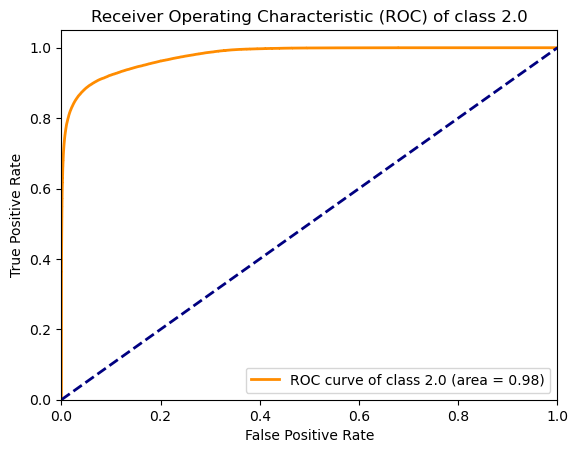

Accuracy: 0.72119590606022
Confusion Matrix: 
[[26544   898   726  2008  2551  2615]
 [ 3717 41003 14225   762   648   494]
 [ 4627 11655 36682  1124  1487   902]
 [ 6511   248   365 22507   792  1425]
 [ 7032   569   565  1214 23738  2671]
 [ 3903   294   356  2560  1836 53310]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.75      0.61     35342
           1       0.75      0.67      0.71     60849
           2       0.69      0.65      0.67     56477
           3       0.75      0.71      0.73     31848
           4       0.76      0.66      0.71     35789
           5       0.87      0.86      0.86     62259

    accuracy                           0.72    282564
   macro avg       0.72      0.72      0.71    282564
weighted avg       0.74      0.72      0.72    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [1]:
# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_with_noise.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
27774/27774 [==============================] - 73s 3ms/step - loss: 1.0406 - accuracy: 0.5761 - val_loss: 0.8432 - val_accuracy: 0.6584
Epoch 2/10
27774/27774 [==============================] - 73s 3ms/step - loss: 0.8537 - accuracy: 0.6540 - val_loss: 0.7660 - val_accuracy: 0.6902
Epoch 3/10
27774/27774 [==============================] - 74s 3ms/step - loss: 0.7939 - accuracy: 0.6777 - val_loss: 0.7222 - val_accuracy: 0.7074
Epoch 4/10
27774/27774 [==============================] - 75s 3ms/step - loss: 0.7614 - accuracy: 0.6907 - val_loss: 0.7032 - val_accuracy: 0.7139
Epoch 5/10
27774/27774 [==============================] - 75s 3ms/step - loss: 0.7380 - accuracy: 0.7006 - val_loss: 0.6848 - val_accuracy: 0.7221
Epoch 6/10
27774/27774 [==============================] - 73s 3ms/step - loss: 0.7200 - accuracy: 0.7076 - val_loss: 0.6737 - val_accuracy: 0.7240
Epoch 7/10
27774/27774 [==============================] - 74s 3ms/step - loss: 0.7056 - accuracy: 0.7137 - val_loss: 0

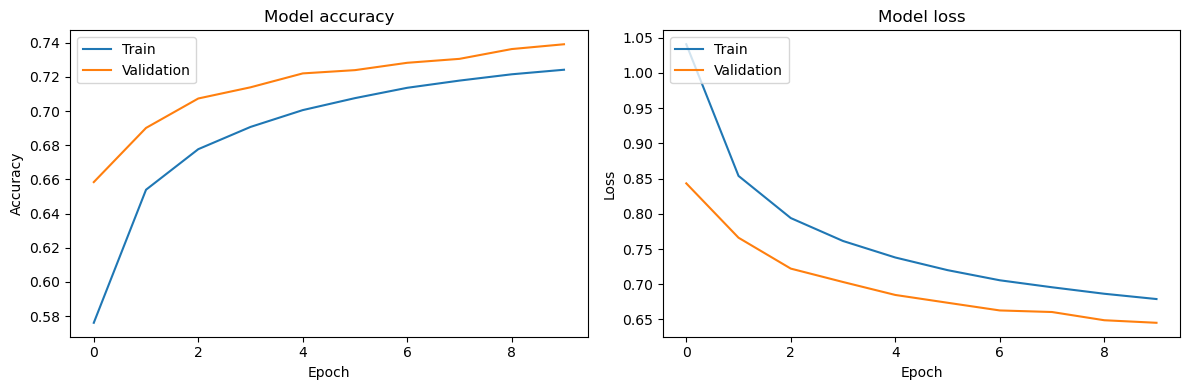

34717/34717 [==============================] - 21s 610us/step


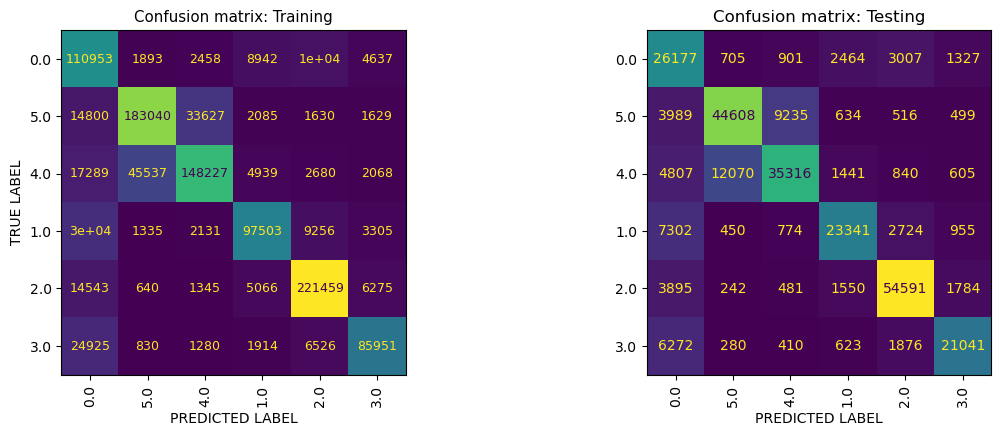

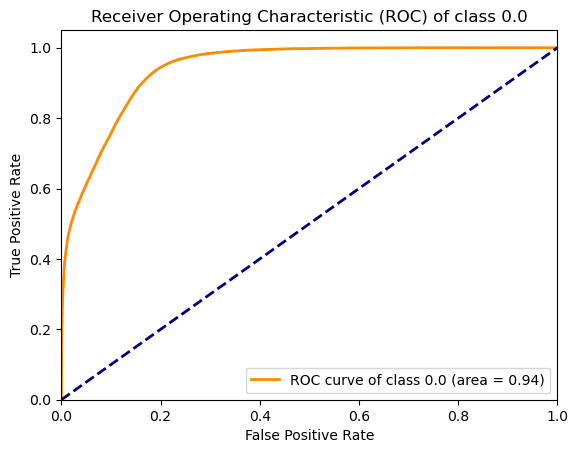

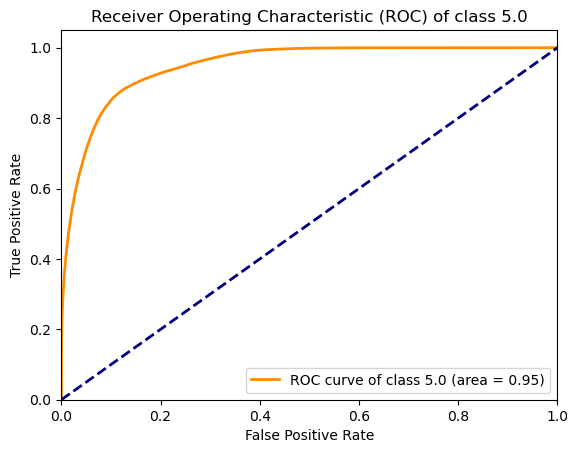

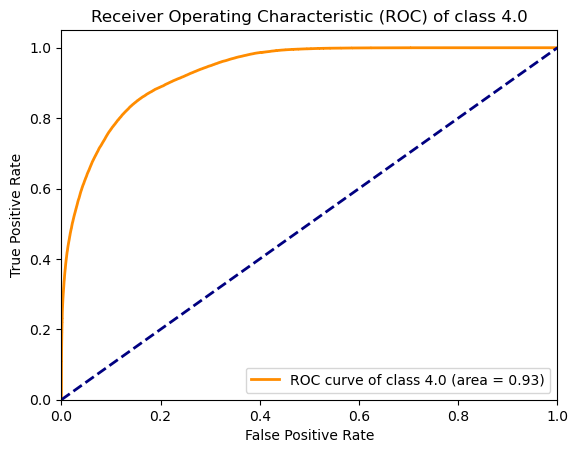

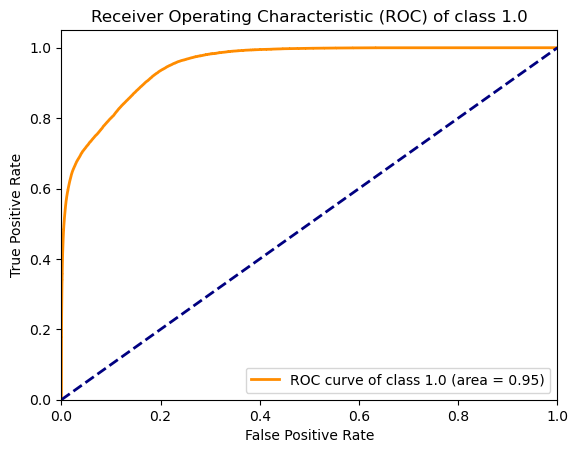

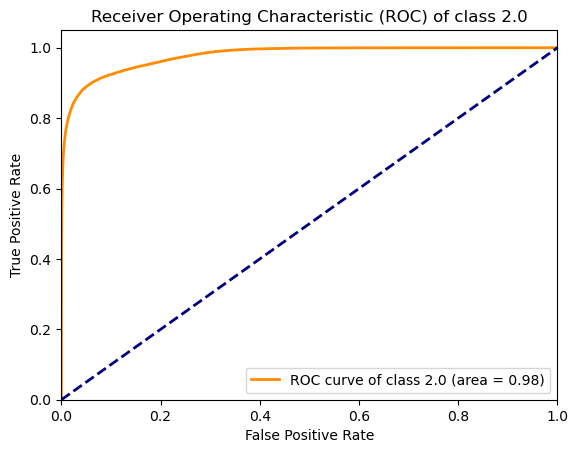

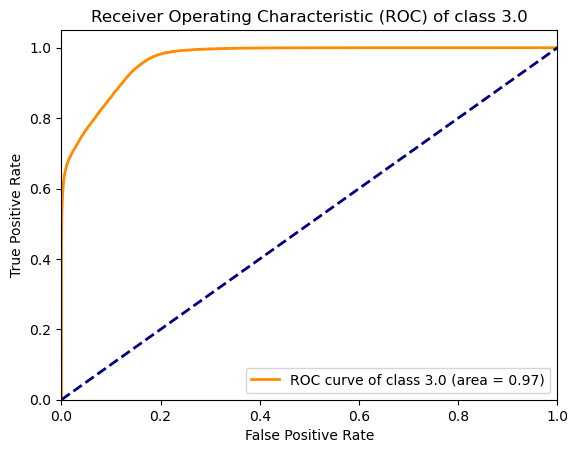

Accuracy: 0.7383880863566316
Confusion Matrix: 
[[26177   705   901  2464  3007  1327]
 [ 3989 44608  9235   634   516   499]
 [ 4807 12070 35316  1441   840   605]
 [ 7302   450   774 23341  2724   955]
 [ 3895   242   481  1550 54591  1784]
 [ 6272   280   410   623  1876 21041]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.76      0.60     34581
           1       0.76      0.75      0.76     59481
           2       0.75      0.64      0.69     55079
           3       0.78      0.66      0.71     35546
           4       0.86      0.87      0.87     62543
           5       0.80      0.69      0.74     30502

    accuracy                           0.74    277732
   macro avg       0.74      0.73      0.73    277732
weighted avg       0.76      0.74      0.74    277732

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [2]:
# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_filtered.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [3]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# 1. 加载数据
data_noisy = pd.read_csv('data_with_noise.csv')

# 2. 初始化孤立森林模型
iso_forest = IsolationForest(contamination=0.2, random_state=42)

# 3. 使用孤立森林模型训练并预测异常值
anomalies_iso = iso_forest.fit_predict(data_noisy.drop(columns=["id", "act"]))

# 4. 将预测值转换为布尔值 (True 表示异常)
anomalies_iso = anomalies_iso == -1

# 5. 过滤掉检测到的异常值
data_filtered_iso = data_noisy[~anomalies_iso]

# 6. 保存过滤后的数据到CSV文件
data_filtered_iso.to_csv('is_DATA.csv', index=False)


Epoch 1/10
22605/22605 [==============================] - 66s 3ms/step - loss: 1.0080 - accuracy: 0.5882 - val_loss: 0.8613 - val_accuracy: 0.6555
Epoch 2/10
22605/22605 [==============================] - 59s 3ms/step - loss: 0.8502 - accuracy: 0.6568 - val_loss: 0.7769 - val_accuracy: 0.6865
Epoch 3/10
22605/22605 [==============================] - 58s 3ms/step - loss: 0.7894 - accuracy: 0.6809 - val_loss: 0.7380 - val_accuracy: 0.7014
Epoch 4/10
22605/22605 [==============================] - 58s 3ms/step - loss: 0.7525 - accuracy: 0.6949 - val_loss: 0.7092 - val_accuracy: 0.7122
Epoch 5/10
22605/22605 [==============================] - 58s 3ms/step - loss: 0.7261 - accuracy: 0.7054 - val_loss: 0.7053 - val_accuracy: 0.7118
Epoch 6/10
22605/22605 [==============================] - 63s 3ms/step - loss: 0.7068 - accuracy: 0.7124 - val_loss: 0.6792 - val_accuracy: 0.7237
Epoch 7/10
22605/22605 [==============================] - 61s 3ms/step - loss: 0.6918 - accuracy: 0.7181 - val_loss: 0

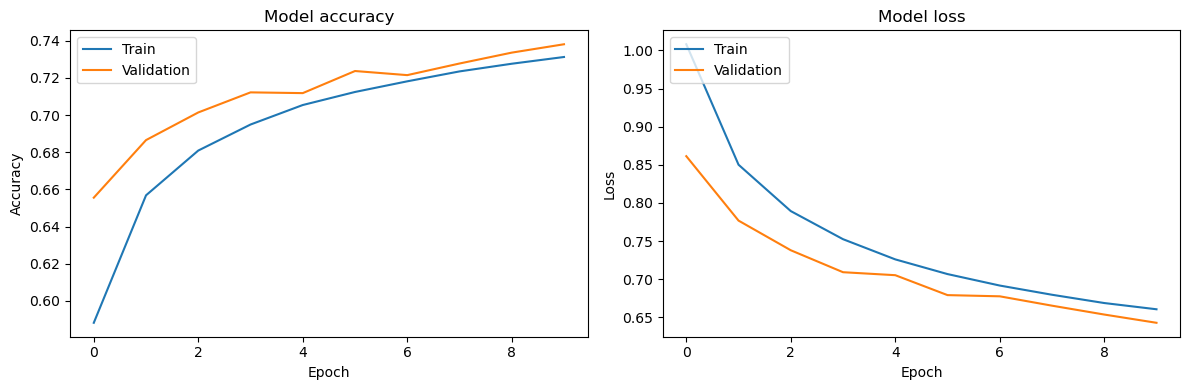

28257/28257 [==============================] - 17s 611us/step


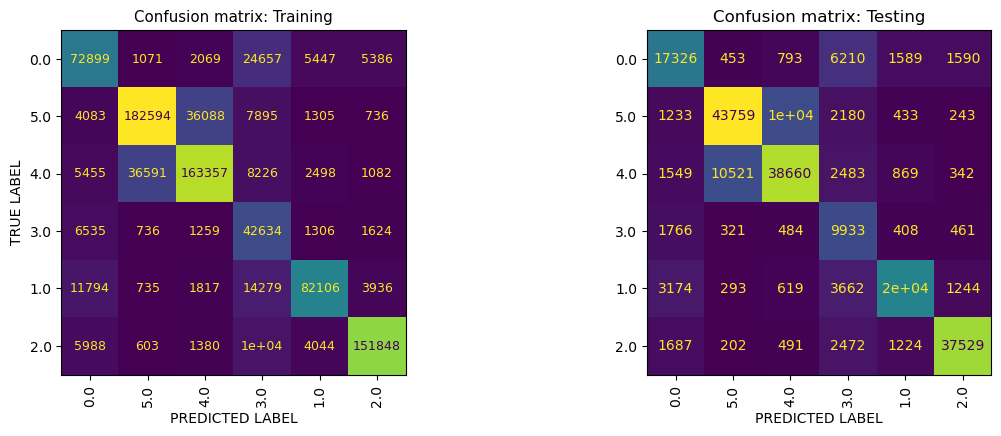

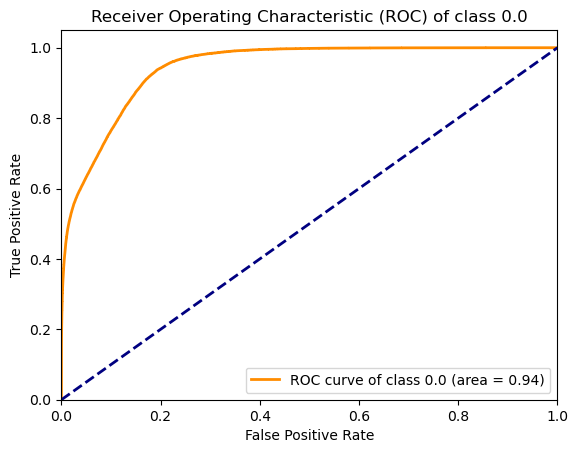

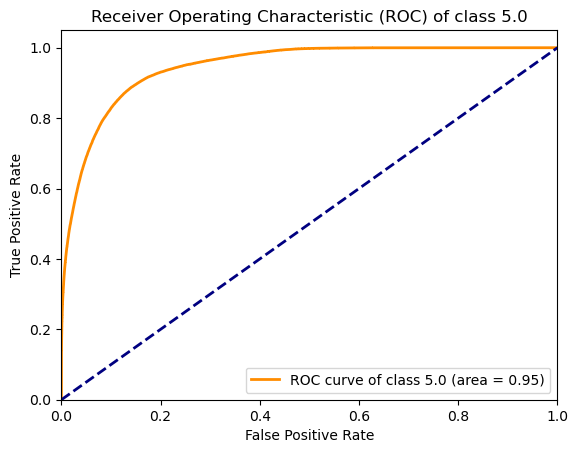

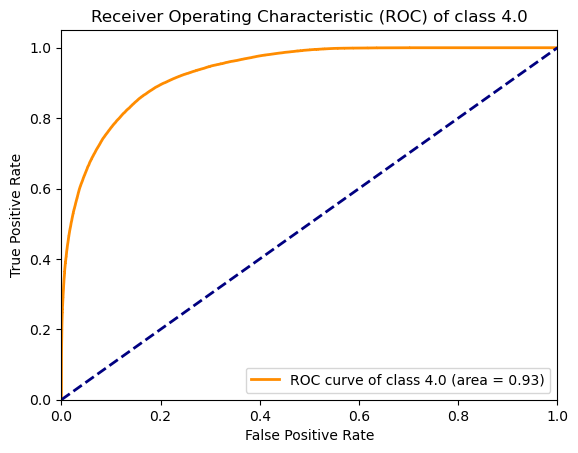

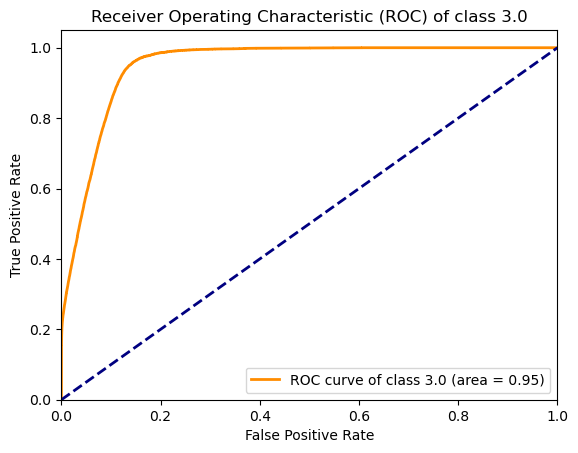

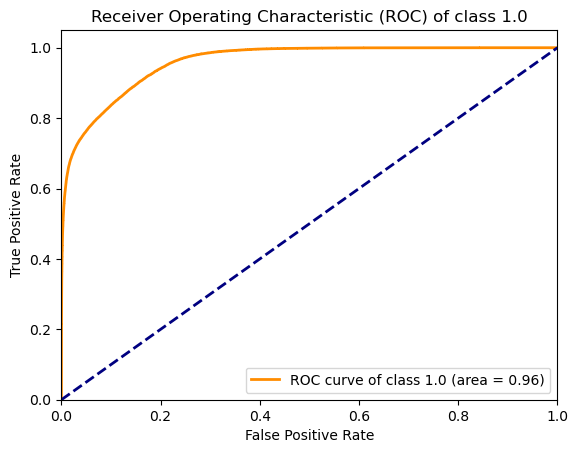

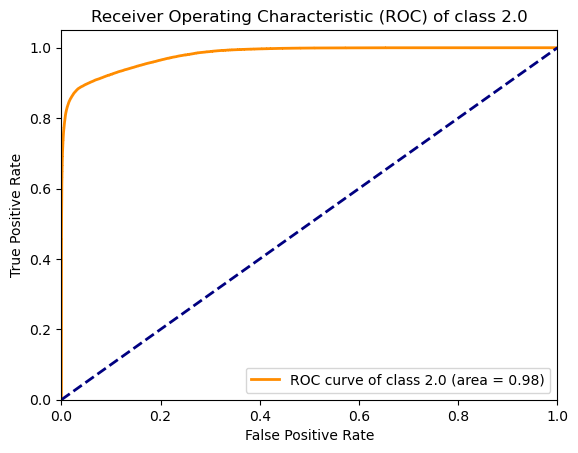

Accuracy: 0.7384637844007272
Confusion Matrix: 
[[17326   453   793  6210  1589  1590]
 [ 1233 43759 10124  2180   433   243]
 [ 1549 10521 38660  2483   869   342]
 [ 1766   321   484  9933   408   461]
 [ 3174   293   619  3662 19722  1244]
 [ 1687   202   491  2472  1224 37529]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     27961
           1       0.79      0.75      0.77     57972
           2       0.76      0.71      0.73     54424
           3       0.37      0.74      0.49     13373
           4       0.81      0.69      0.74     28714
           5       0.91      0.86      0.88     43605

    accuracy                           0.74    226049
   macro avg       0.71      0.73      0.71    226049
weighted avg       0.76      0.74      0.75    226049

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [4]:
# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'is_DATA.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [5]:

# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_filtered_fft.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
26844/26844 [==============================] - 80s 3ms/step - loss: 1.0491 - accuracy: 0.5647 - val_loss: 0.8627 - val_accuracy: 0.6365
Epoch 2/10
26844/26844 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.6378

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np

# 1. 加载数据
data_noisy = pd.read_csv('data_with_noise.csv')

# 2. 计算移动平均和移动标准差
window_size = 50  # 定义窗口大小
multiplier = 2.5  # 定义一个乘数，用于设置标准差的阈值

rolling_mean = data_noisy['userAcceleration.x'].rolling(window=window_size).mean()
rolling_std = data_noisy['userAcceleration.x'].rolling(window=window_size).std()

# 3. 标识异常值
anomalies_rolling = np.abs(data_noisy['userAcceleration.x'] - rolling_mean) > (multiplier * rolling_std)

# 4. 过滤出检测到的异常值
data_filtered_rolling = data_noisy[~anomalies_rolling]

# 5. 保存过滤后的数据到CSV文件
data_filtered_rolling.to_csv('data_rolling.csv', index=False)


In [8]:

# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_rolling.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


KeyboardInterrupt: 

In [3]:
  import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# 1. 加载数据
data_noisy = pd.read_csv('data_with_noise.csv')

# 2. 应用LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)  # contamination is set to 20% as we introduced 20% noise
labels_lof = lof.fit_predict(data_noisy.drop(columns=["id", "act"]))

# 3. 标识异常值
# 在LOF中，标签为-1的数据点被认为是异常值
anomalies_lof = labels_lof == -1

# 4. 过滤出检测到的异常值
data_filtered_lof = data_noisy[~anomalies_lof]

# 5. 保存过滤后的数据到CSV文件
data_filtered_lof.to_csv('data_lof.csv', index=False)


Epoch 1/10
22605/22605 [==============================] - 64s 3ms/step - loss: 1.0276 - accuracy: 0.5743 - val_loss: 0.8340 - val_accuracy: 0.6544
Epoch 2/10
22605/22605 [==============================] - 60s 3ms/step - loss: 0.8383 - accuracy: 0.6543 - val_loss: 0.7480 - val_accuracy: 0.6928
Epoch 3/10
22605/22605 [==============================] - 60s 3ms/step - loss: 0.7773 - accuracy: 0.6810 - val_loss: 0.7215 - val_accuracy: 0.7028
Epoch 4/10
22605/22605 [==============================] - 59s 3ms/step - loss: 0.7411 - accuracy: 0.6957 - val_loss: 0.7004 - val_accuracy: 0.7141
Epoch 5/10
22605/22605 [==============================] - 60s 3ms/step - loss: 0.7167 - accuracy: 0.7069 - val_loss: 0.6733 - val_accuracy: 0.7240
Epoch 6/10
22605/22605 [==============================] - 60s 3ms/step - loss: 0.6980 - accuracy: 0.7138 - val_loss: 0.6529 - val_accuracy: 0.7299
Epoch 7/10
22605/22605 [==============================] - 60s 3ms/step - loss: 0.6835 - accuracy: 0.7200 - val_loss: 0

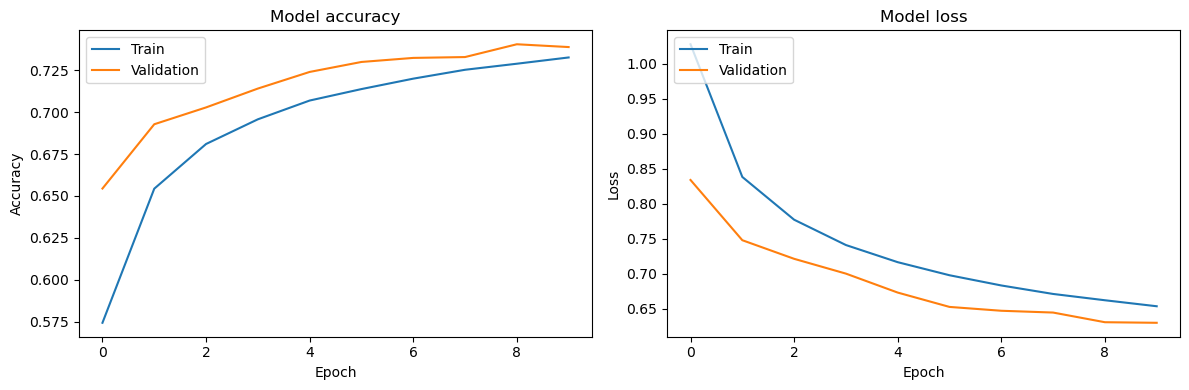

28257/28257 [==============================] - 17s 605us/step


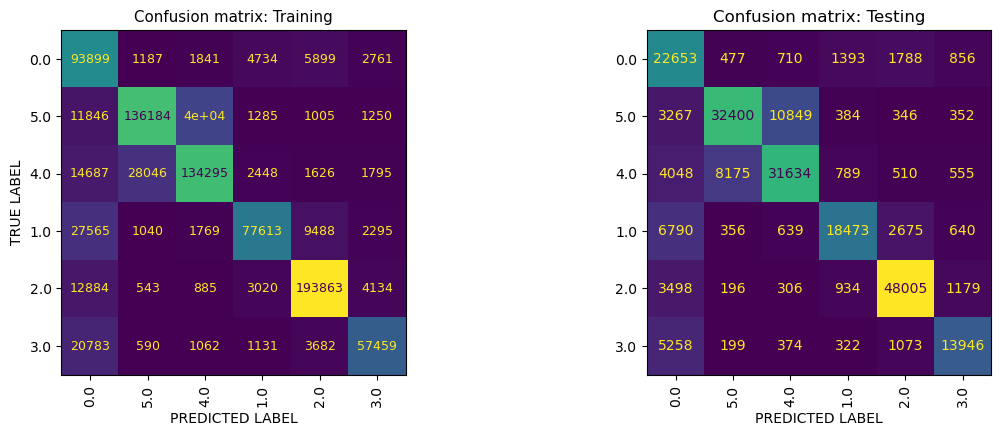

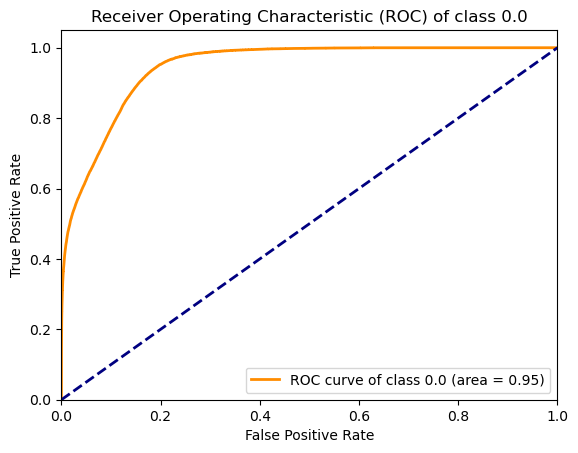

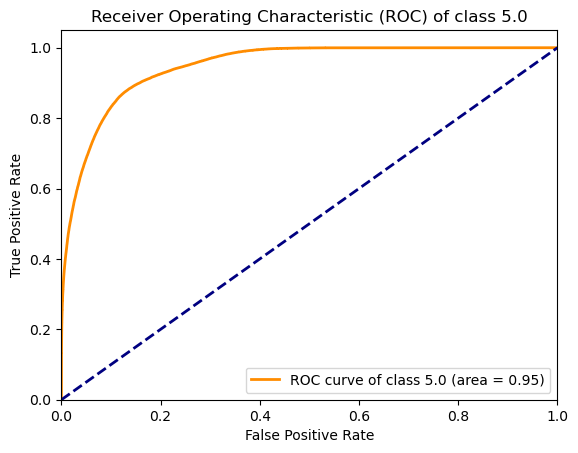

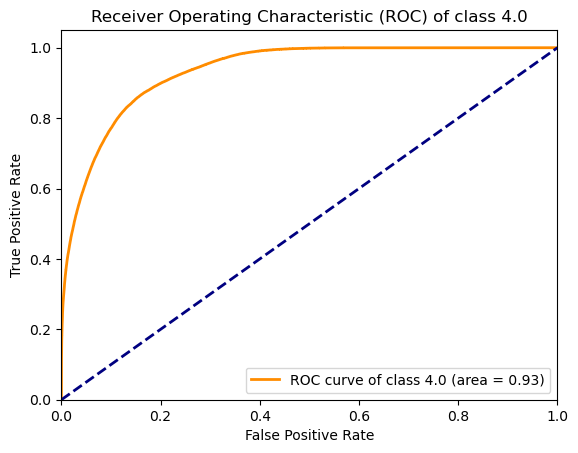

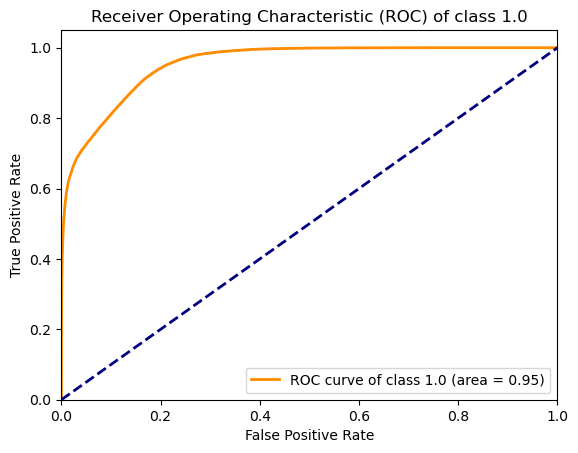

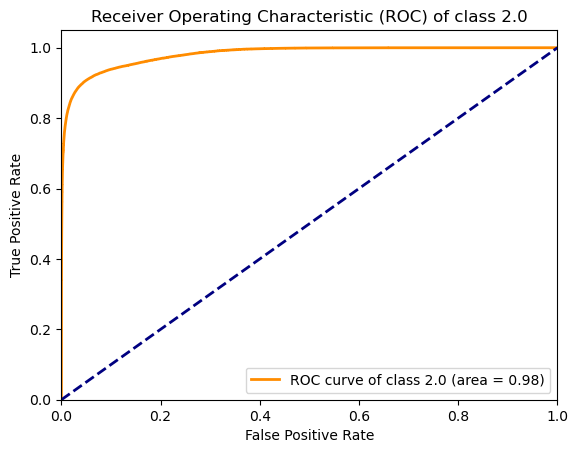

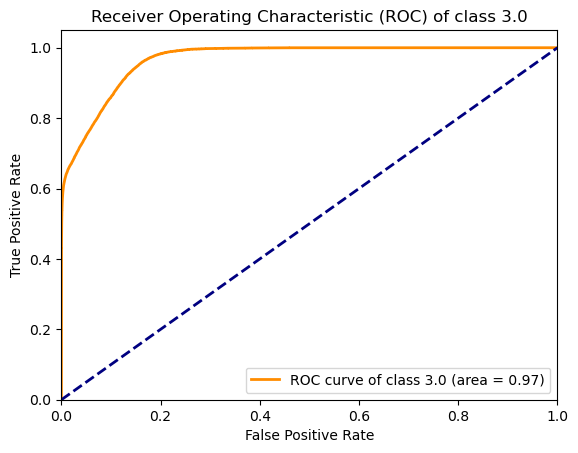

Accuracy: 0.7392689195705356
Confusion Matrix: 
[[22653   477   710  1393  1788   856]
 [ 3267 32400 10849   384   346   352]
 [ 4048  8175 31634   789   510   555]
 [ 6790   356   639 18473  2675   640]
 [ 3498   196   306   934 48005  1179]
 [ 5258   199   374   322  1073 13946]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.81      0.62     27877
           1       0.78      0.68      0.72     47598
           2       0.71      0.69      0.70     45711
           3       0.83      0.62      0.71     29573
           4       0.88      0.89      0.88     54118
           5       0.80      0.66      0.72     21172

    accuracy                           0.74    226049
   macro avg       0.75      0.73      0.73    226049
weighted avg       0.76      0.74      0.74    226049

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [4]:

# 含噪音的数据
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_lof.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [24]:
dataset = pd.read_csv('clean.csv')

# Function to clean data within each activity group
def clean_within_group(group):
    for column in group.columns:
        if column not in ["act", "id"]:  # Skip non-sensor columns
            mean = group[column].mean()
            std = group[column].std()
            mask = (group[column] > mean - 0.4*std) & (group[column] < mean + 0.4*std)
            group.loc[mask, column] = np.nan
    return group.dropna()

# Apply the cleaning function to each activity group
df_cleaned_by_activity = dataset.groupby('act').apply(clean_within_group).reset_index(drop=True)


# 4. 保存清理后的数据到CSV文件
df_cleaned_by_activity.to_csv('data_cleaned2.csv', index=False)




Epoch 1/10
1833/1833 [==============================] - 7s 3ms/step - loss: 0.6676 - accuracy: 0.7393 - val_loss: 0.3985 - val_accuracy: 0.8525
Epoch 2/10
1833/1833 [==============================] - 6s 3ms/step - loss: 0.3578 - accuracy: 0.8660 - val_loss: 0.2588 - val_accuracy: 0.9073
Epoch 3/10
1833/1833 [==============================] - 7s 4ms/step - loss: 0.2562 - accuracy: 0.9054 - val_loss: 0.1937 - val_accuracy: 0.9299
Epoch 4/10
1833/1833 [==============================] - 7s 4ms/step - loss: 0.1930 - accuracy: 0.9290 - val_loss: 0.1690 - val_accuracy: 0.9377
Epoch 5/10
1833/1833 [==============================] - 6s 3ms/step - loss: 0.1505 - accuracy: 0.9457 - val_loss: 0.1190 - val_accuracy: 0.9588
Epoch 6/10
1833/1833 [==============================] - 7s 4ms/step - loss: 0.1187 - accuracy: 0.9578 - val_loss: 0.1106 - val_accuracy: 0.9619
Epoch 7/10
1833/1833 [==============================] - 7s 4ms/step - loss: 0.0994 - accuracy: 0.9647 - val_loss: 0.0962 - val_accuracy:

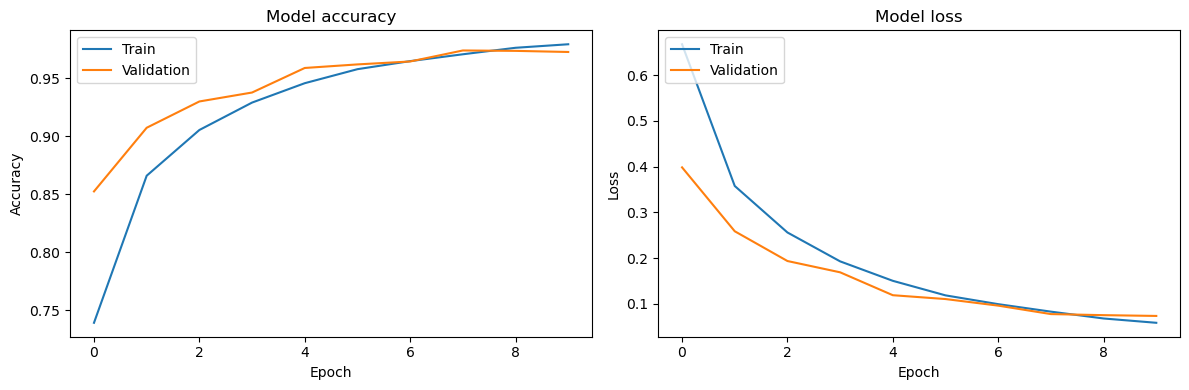

2291/2291 [==============================] - 2s 853us/step


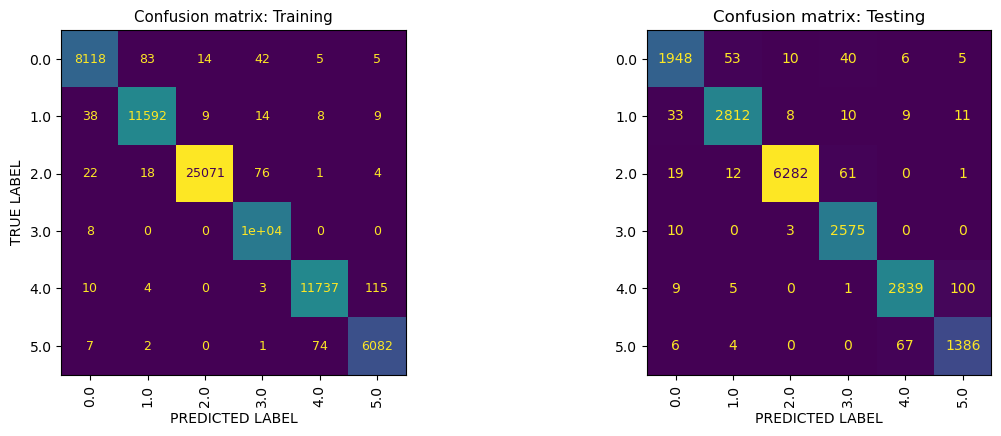

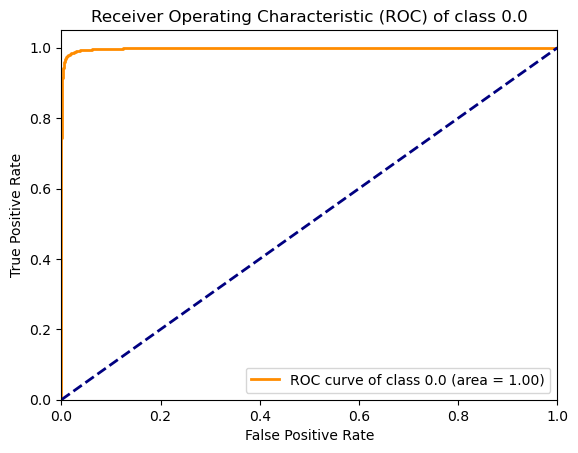

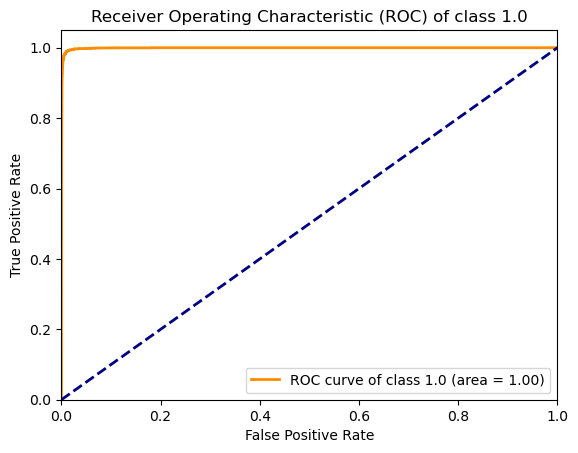

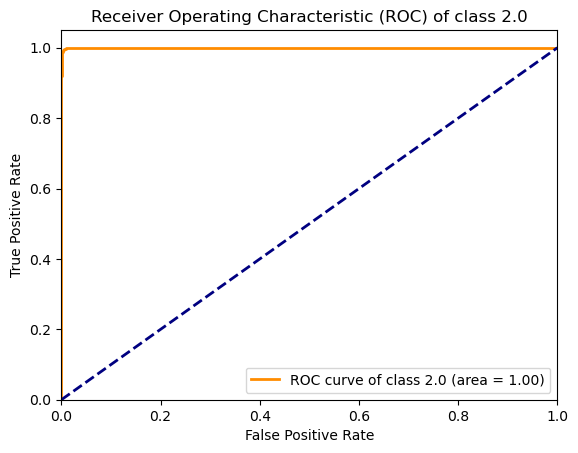

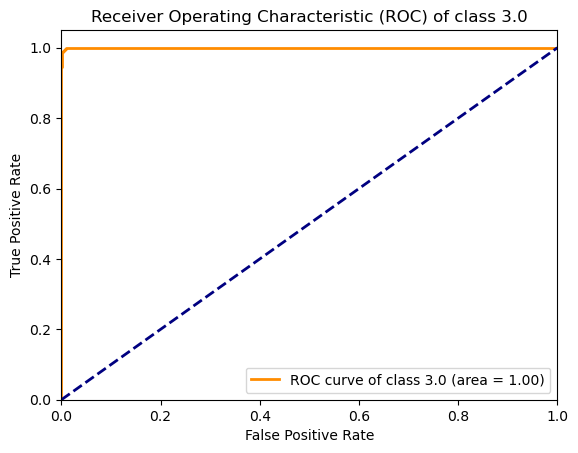

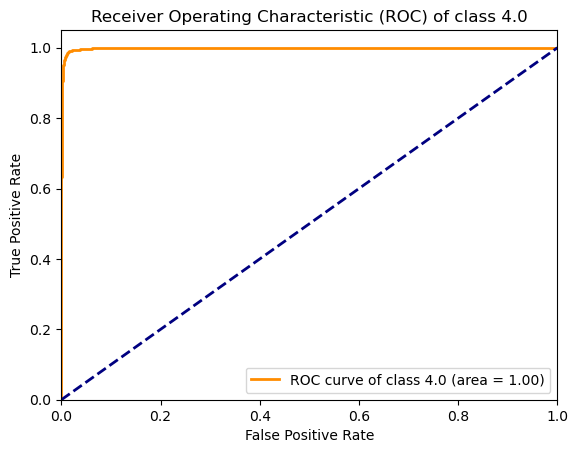

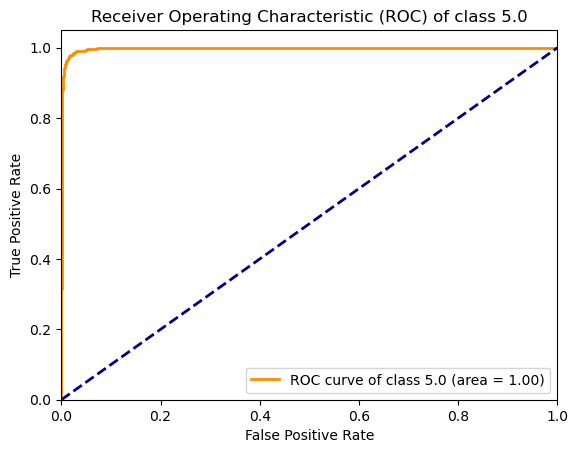

Accuracy: 0.9736425648021828
Confusion Matrix: 
[[1948   53   10   40    6    5]
 [  33 2812    8   10    9   11]
 [  19   12 6282   61    0    1]
 [  10    0    3 2575    0    0]
 [   9    5    0    1 2839  100]
 [   6    4    0    0   67 1386]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2062
           1       0.97      0.98      0.97      2883
           2       1.00      0.99      0.99      6375
           3       0.96      0.99      0.98      2588
           4       0.97      0.96      0.97      2954
           5       0.92      0.95      0.93      1463

    accuracy                           0.97     18325
   macro avg       0.96      0.97      0.97     18325
weighted avg       0.97      0.97      0.97     18325

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_cleaned2.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
25782/25782 [==============================] - 69s 3ms/step - loss: 0.2796 - accuracy: 0.9111 - val_loss: 0.1670 - val_accuracy: 0.9482
Epoch 2/10
25782/25782 [==============================] - 65s 3ms/step - loss: 0.1683 - accuracy: 0.9468 - val_loss: 0.1432 - val_accuracy: 0.9539
Epoch 3/10
25782/25782 [==============================] - 67s 3ms/step - loss: 0.1412 - accuracy: 0.9550 - val_loss: 0.1205 - val_accuracy: 0.9618
Epoch 4/10
25782/25782 [==============================] - 69s 3ms/step - loss: 0.1242 - accuracy: 0.9595 - val_loss: 0.1097 - val_accuracy: 0.9650
Epoch 5/10
25782/25782 [==============================] - 70s 3ms/step - loss: 0.1125 - accuracy: 0.9628 - val_loss: 0.1010 - val_accuracy: 0.9676
Epoch 6/10
25782/25782 [==============================] - 66s 3ms/step - loss: 0.1033 - accuracy: 0.9655 - val_loss: 0.0976 - val_accuracy: 0.9691
Epoch 7/10
25782/25782 [==============================] - 71s 3ms/step - loss: 0.0963 - accuracy: 0.9676 - val_loss: 0

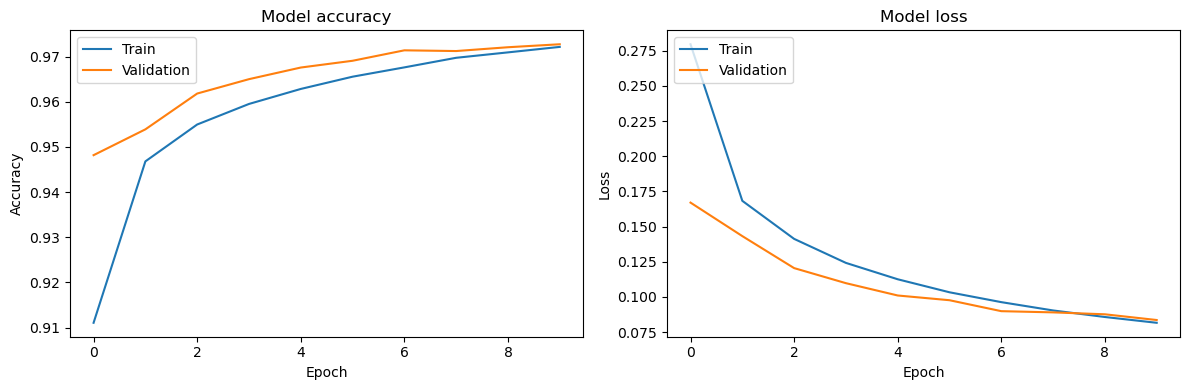

32228/32228 [==============================] - 21s 644us/step


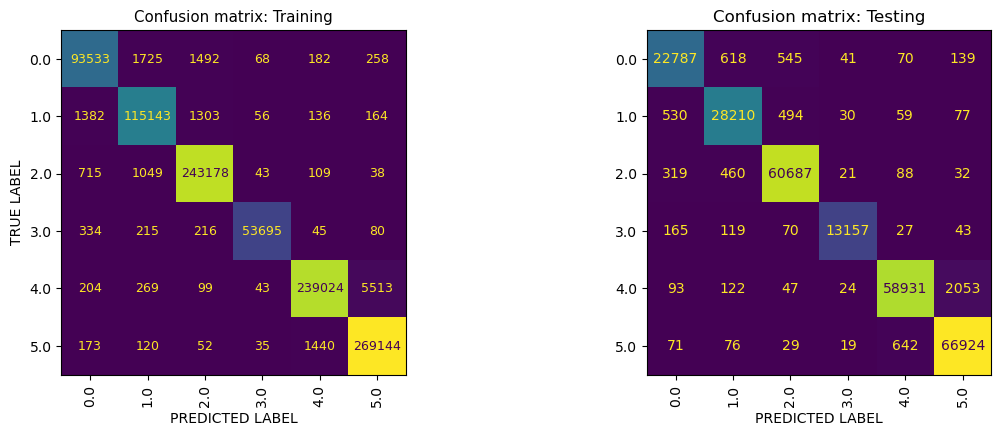

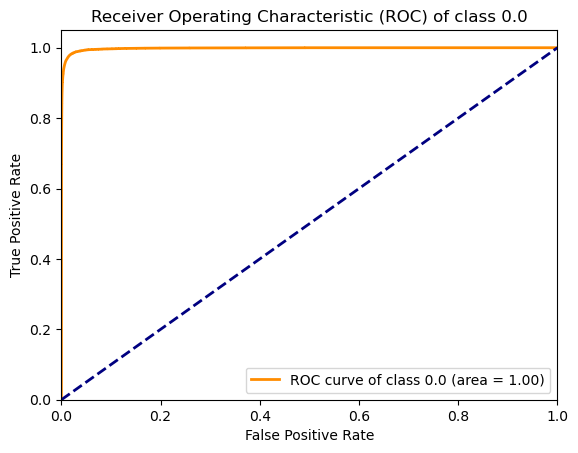

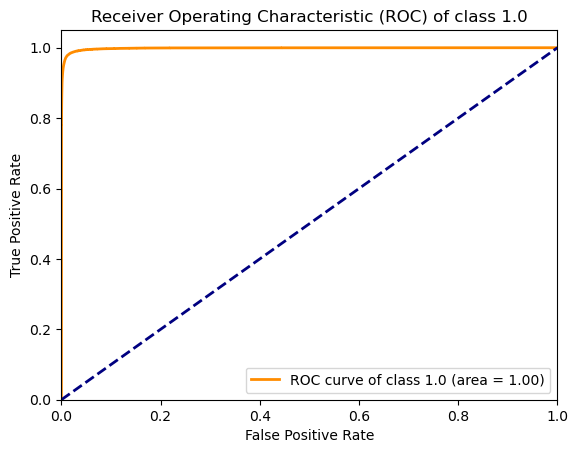

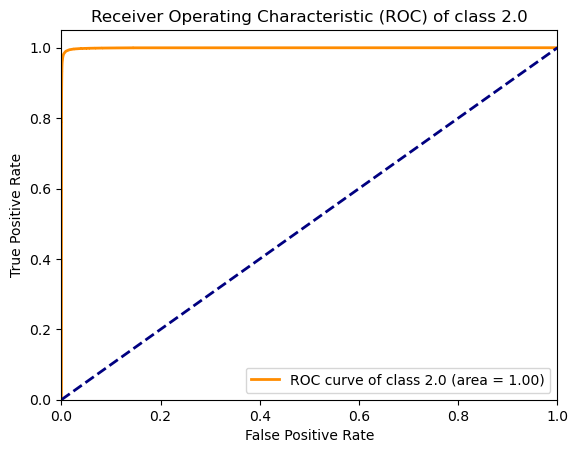

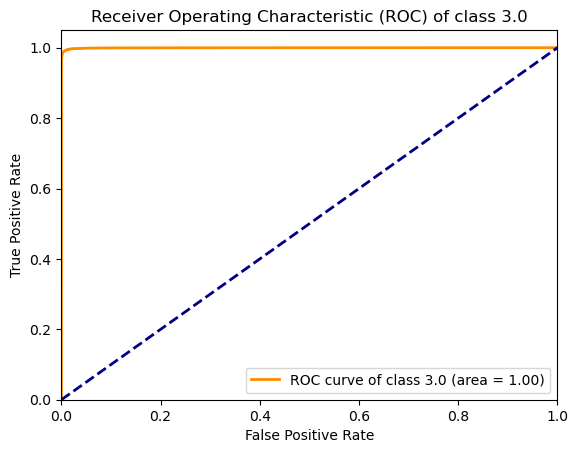

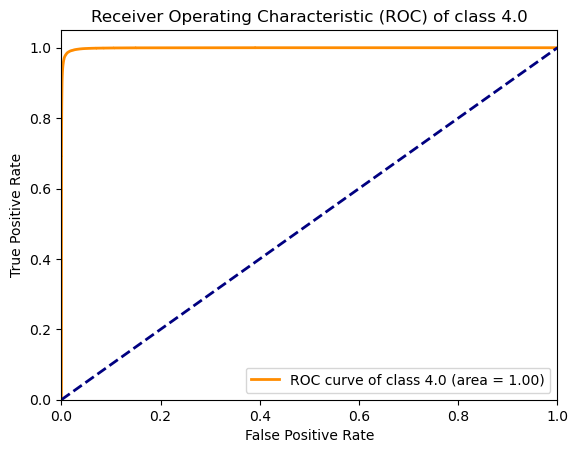

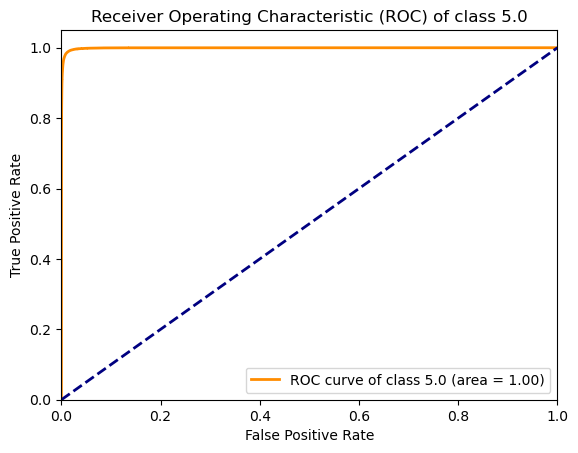

Accuracy: 0.9723720904975971
Confusion Matrix: 
[[22787   618   545    41    70   139]
 [  530 28210   494    30    59    77]
 [  319   460 60687    21    88    32]
 [  165   119    70 13157    27    43]
 [   93   122    47    24 58931  2053]
 [   71    76    29    19   642 66924]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24200
           1       0.95      0.96      0.96     29400
           2       0.98      0.99      0.98     61607
           3       0.99      0.97      0.98     13581
           4       0.99      0.96      0.97     61270
           5       0.97      0.99      0.98     67761

    accuracy                           0.97    257819
   macro avg       0.97      0.97      0.97    257819
weighted avg       0.97      0.97      0.97    257819

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'cleaned_data.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


Epoch 1/10
28257/28257 [==============================] - 73s 3ms/step - loss: 0.2515 - accuracy: 0.9215 - val_loss: 0.1475 - val_accuracy: 0.9558
Epoch 2/10
28257/28257 [==============================] - 78s 3ms/step - loss: 0.1512 - accuracy: 0.9534 - val_loss: 0.1317 - val_accuracy: 0.9590
Epoch 3/10
28257/28257 [==============================] - 74s 3ms/step - loss: 0.1264 - accuracy: 0.9601 - val_loss: 0.1120 - val_accuracy: 0.9652
Epoch 4/10
28257/28257 [==============================] - 72s 3ms/step - loss: 0.1115 - accuracy: 0.9641 - val_loss: 0.0987 - val_accuracy: 0.9694
Epoch 5/10
28257/28257 [==============================] - 79s 3ms/step - loss: 0.1002 - accuracy: 0.9672 - val_loss: 0.0955 - val_accuracy: 0.9699
Epoch 6/10
28257/28257 [==============================] - 73s 3ms/step - loss: 0.0926 - accuracy: 0.9695 - val_loss: 0.0921 - val_accuracy: 0.9701
Epoch 7/10
28257/28257 [==============================] - 81s 3ms/step - loss: 0.0861 - accuracy: 0.9714 - val_loss: 0

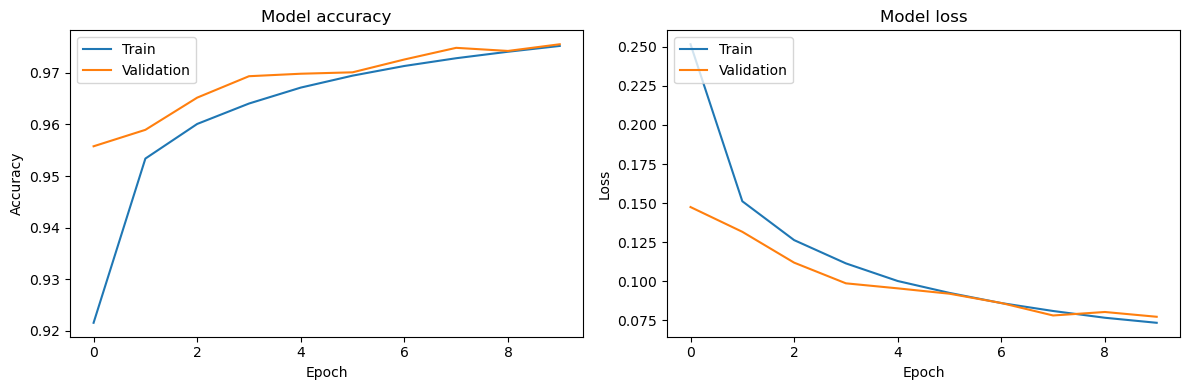

35321/35321 [==============================] - 24s 674us/step


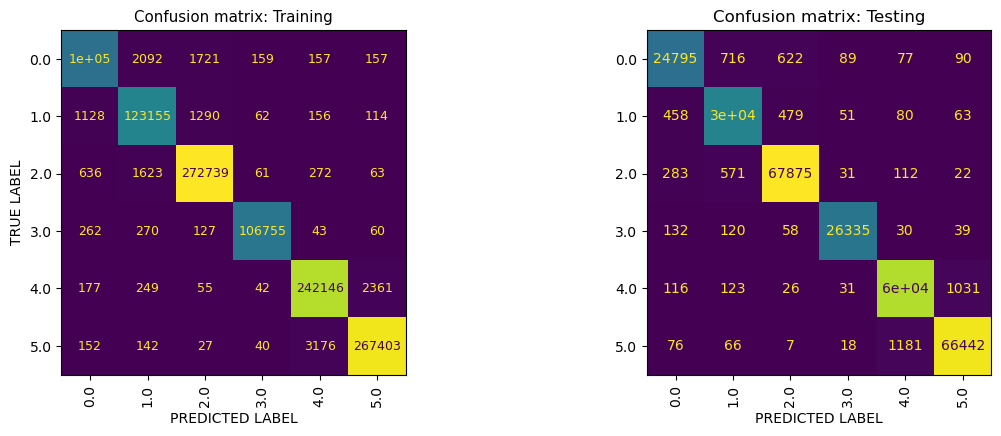

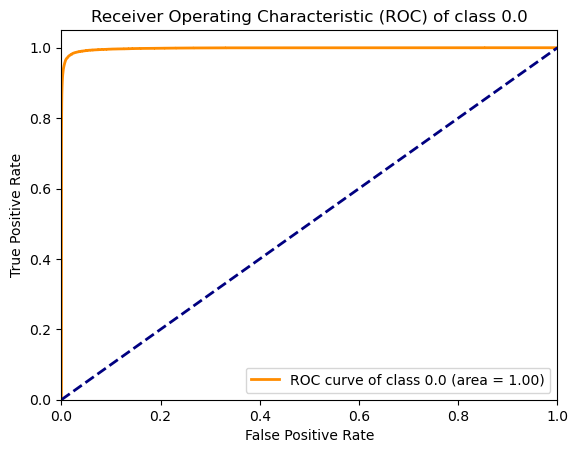

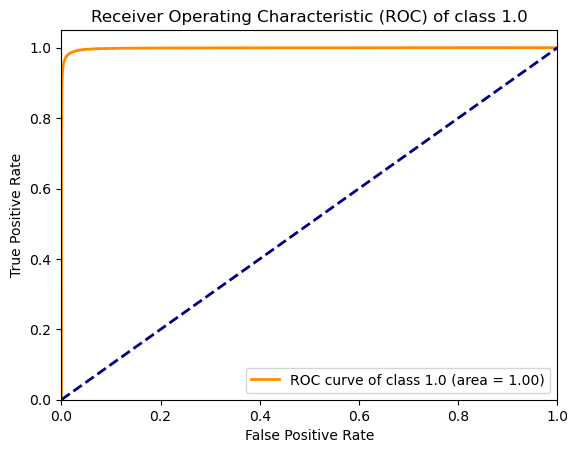

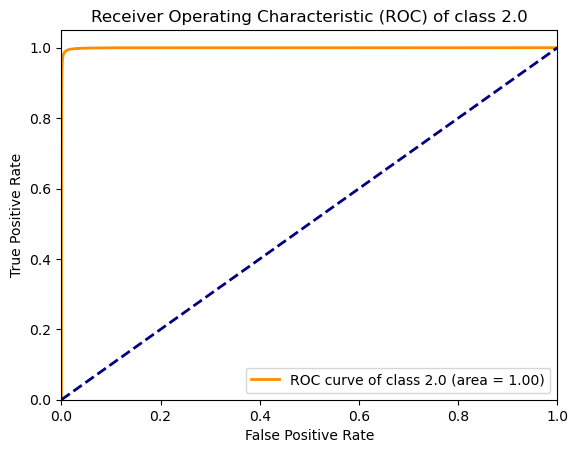

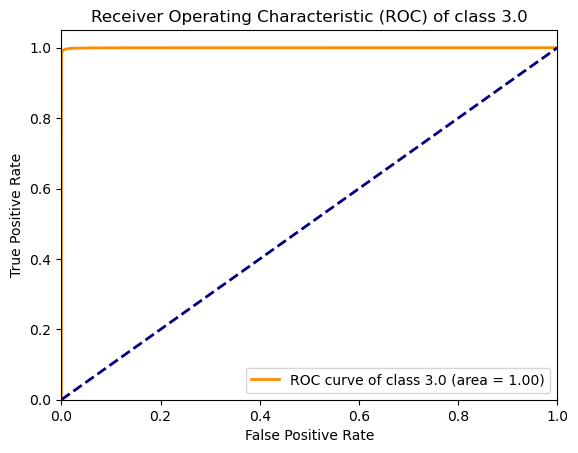

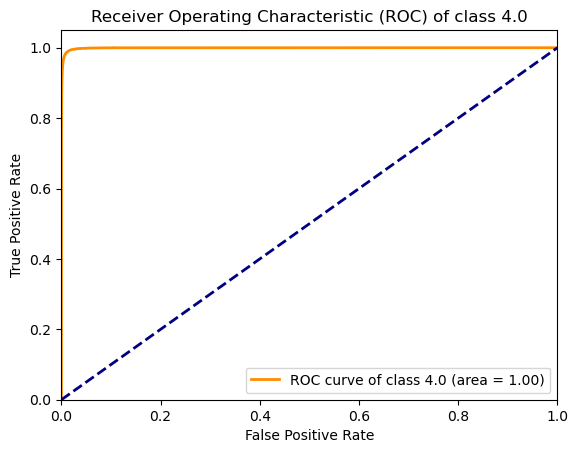

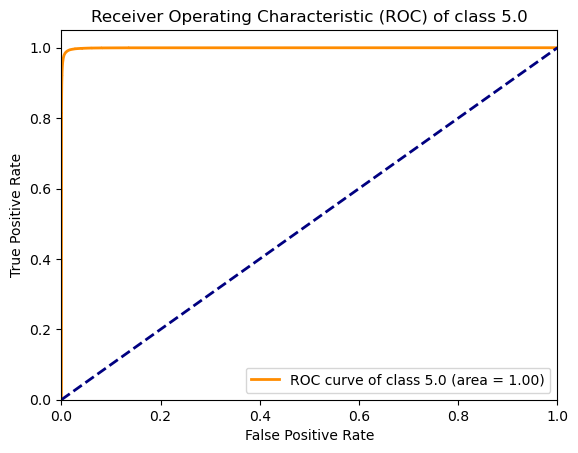

Accuracy: 0.9759417335541682
Confusion Matrix: 
[[24795   716   622    89    77    90]
 [  458 30249   479    51    80    63]
 [  283   571 67875    31   112    22]
 [  132   120    58 26335    30    39]
 [  116   123    26    31 60070  1031]
 [   76    66     7    18  1181 66442]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     26389
           1       0.95      0.96      0.96     31380
           2       0.98      0.99      0.98     68894
           3       0.99      0.99      0.99     26714
           4       0.98      0.98      0.98     61397
           5       0.98      0.98      0.98     67790

    accuracy                           0.98    282564
   macro avg       0.97      0.97      0.97    282564
weighted avg       0.98      0.98      0.98    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [27]:

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'data_with_replaced_outliers.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [30]:
# Reload the original dataset
all_outlier_indices = set()
original_data = pd.read_csv('data_with_noise.csv')

# Drop all outlier rows based on the identified indices
data_cleaned = original_data.drop(all_outlier_indices)

# Reset the index after dropping rows
data_cleaned.reset_index(drop=True, inplace=True)

# Check the shape of the dataset after removing outliers
data_cleaned.shape

data_cleaned.to_csv('data_cleaned3.csv', index=False)

Epoch 1/10
28257/28257 [==============================] - 78s 3ms/step - loss: 0.2383 - accuracy: 0.9260 - val_loss: 0.1458 - val_accuracy: 0.9558
Epoch 2/10
28257/28257 [==============================] - 79s 3ms/step - loss: 0.1450 - accuracy: 0.9552 - val_loss: 0.1171 - val_accuracy: 0.9642
Epoch 3/10
28257/28257 [==============================] - 91s 3ms/step - loss: 0.1217 - accuracy: 0.9614 - val_loss: 0.1089 - val_accuracy: 0.9658
Epoch 4/10
28257/28257 [==============================] - 81s 3ms/step - loss: 0.1083 - accuracy: 0.9651 - val_loss: 0.0959 - val_accuracy: 0.9696
Epoch 5/10
28257/28257 [==============================] - 89s 3ms/step - loss: 0.0976 - accuracy: 0.9680 - val_loss: 0.0900 - val_accuracy: 0.9713
Epoch 6/10
28257/28257 [==============================] - 81s 3ms/step - loss: 0.0903 - accuracy: 0.9702 - val_loss: 0.0853 - val_accuracy: 0.9727
Epoch 7/10
28257/28257 [==============================] - 86s 3ms/step - loss: 0.0844 - accuracy: 0.9721 - val_loss: 0

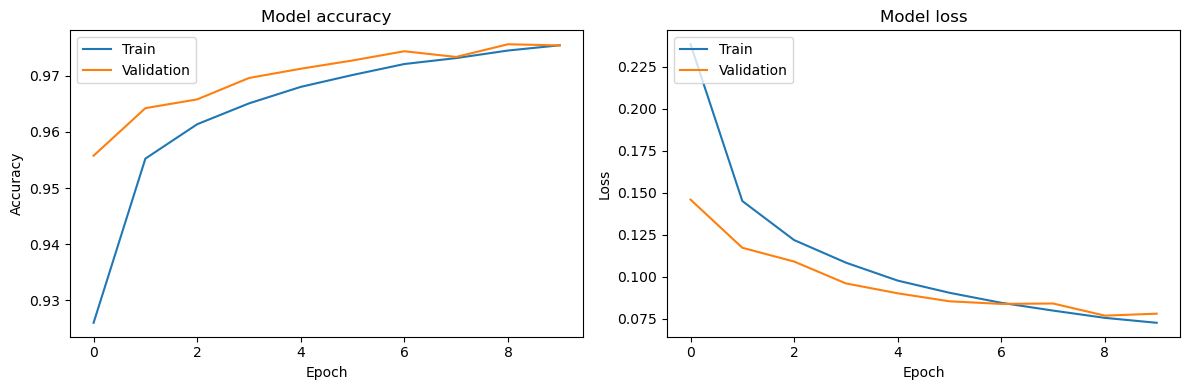

35321/35321 [==============================] - 24s 676us/step


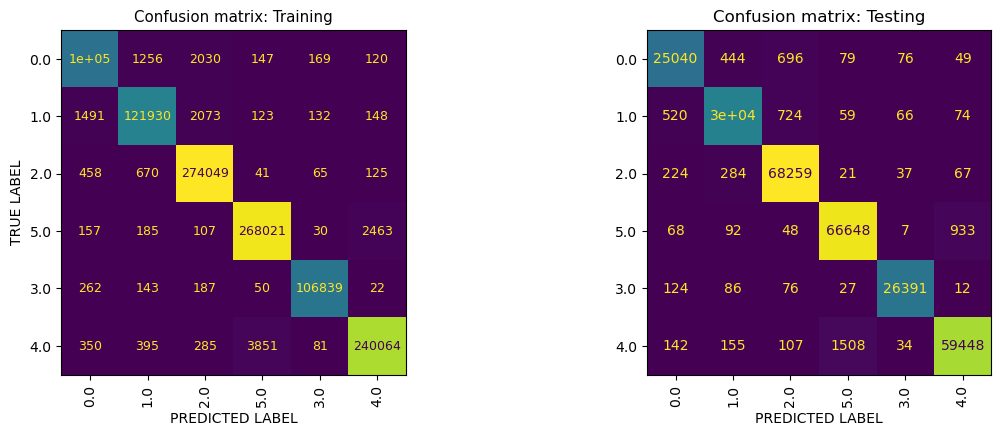

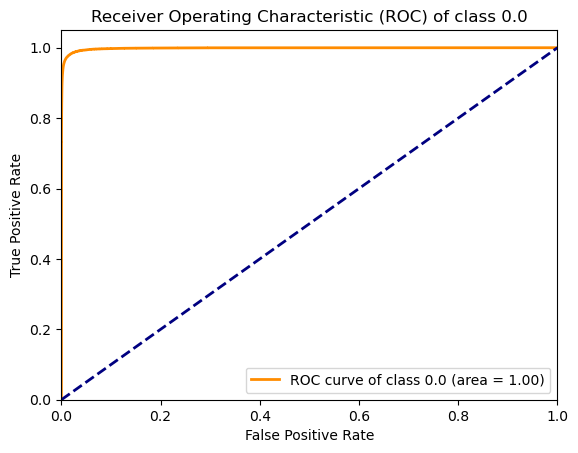

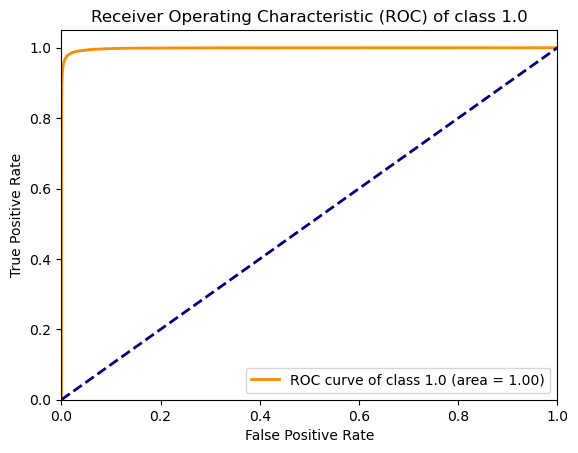

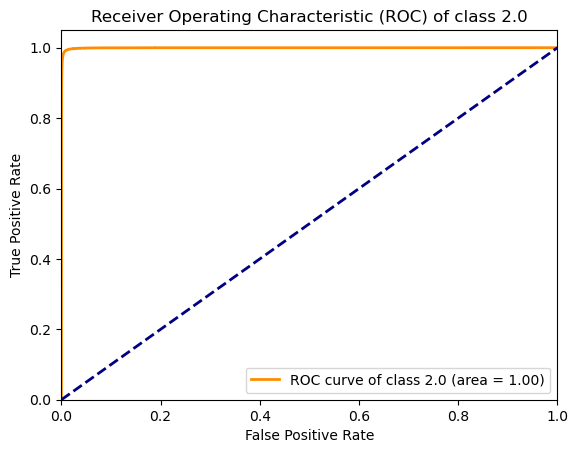

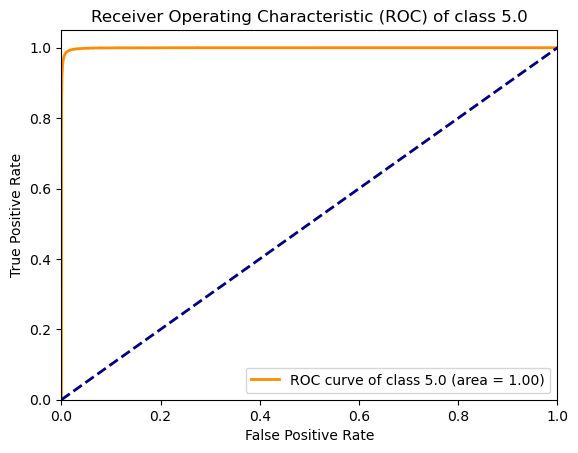

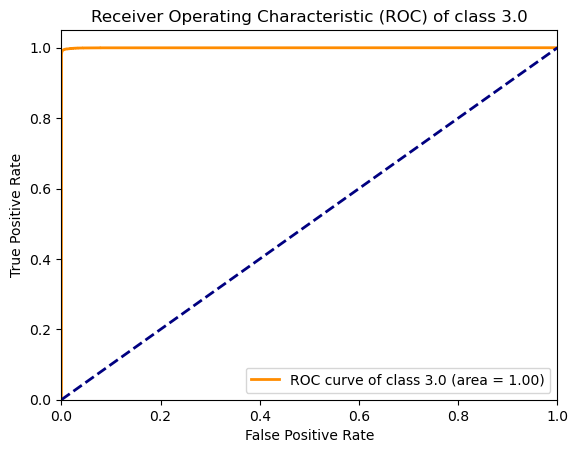

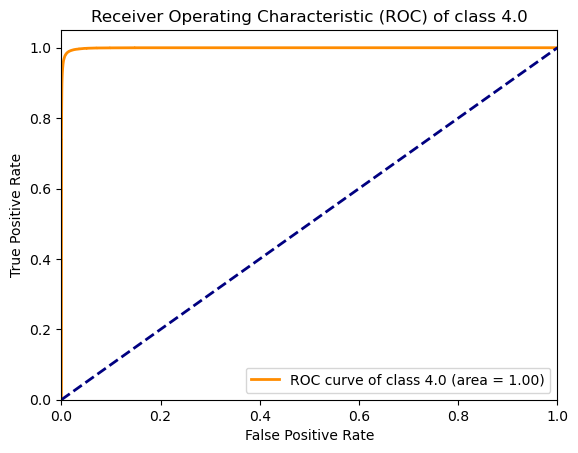

Accuracy: 0.9757966336829886
Confusion Matrix: 
[[25040   444   696    79    76    49]
 [  520 29939   724    59    66    74]
 [  224   284 68259    21    37    67]
 [   68    92    48 66648     7   933]
 [  124    86    76    27 26391    12]
 [  142   155   107  1508    34 59448]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     26384
           1       0.97      0.95      0.96     31382
           2       0.98      0.99      0.98     68892
           3       0.98      0.98      0.98     67796
           4       0.99      0.99      0.99     26716
           5       0.98      0.97      0.97     61394

    accuracy                           0.98    282564
   macro avg       0.97      0.97      0.97    282564
weighted avg       0.98      0.98      0.98    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [36]:

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_with_noise_added.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [34]:
import pandas as pd

# Load the data
data = pd.read_csv('clean_reduced.csv')

# Function to get outliers based on the statistical method for each 'act' label
def get_outliers_statistical(data):
    outliers_indices = []
    unique_acts = data['act'].unique()
    
    for act in unique_acts:
        act_data = data[data['act'] == act]
        
        for column in act_data.drop(columns='act').columns:
            # Calculate the mean and standard deviation of the column for the specific 'act' label
            mean = act_data[column].mean()
            std = act_data[column].std()
            
            # Define the upper and lower bounds for outliers
            lower_bound = mean - 3*std
            upper_bound = mean + 3*std
            
            # Find the outliers and add their indices to the list
            outliers_indices.extend(act_data[(act_data[column] < lower_bound) | (act_data[column] > upper_bound)].index.tolist())
    
    # Return the unique outlier indices
    return data.iloc[list(set(outliers_indices))]

# Get the outliers
outliers_data = get_outliers_statistical(data)

# Save the outliers data to a CSV file
outliers_data.to_csv('clean_reduced_result.csv', index=False)


Epoch 1/10
1189/1189 [==============================] - 4s 3ms/step - loss: 1.1102 - accuracy: 0.5314 - val_loss: 0.8621 - val_accuracy: 0.6278
Epoch 2/10
1189/1189 [==============================] - 3s 3ms/step - loss: 0.7974 - accuracy: 0.6621 - val_loss: 0.7579 - val_accuracy: 0.6676
Epoch 3/10
1189/1189 [==============================] - 4s 3ms/step - loss: 0.6854 - accuracy: 0.7132 - val_loss: 0.6941 - val_accuracy: 0.7002
Epoch 4/10
1189/1189 [==============================] - 3s 3ms/step - loss: 0.6063 - accuracy: 0.7479 - val_loss: 0.6446 - val_accuracy: 0.7301
Epoch 5/10
1189/1189 [==============================] - 4s 3ms/step - loss: 0.5370 - accuracy: 0.7836 - val_loss: 0.6053 - val_accuracy: 0.7459
Epoch 6/10
1189/1189 [==============================] - 3s 3ms/step - loss: 0.4828 - accuracy: 0.8084 - val_loss: 0.5834 - val_accuracy: 0.7591
Epoch 7/10
1189/1189 [==============================] - 3s 3ms/step - loss: 0.4252 - accuracy: 0.8326 - val_loss: 0.5600 - val_accuracy:

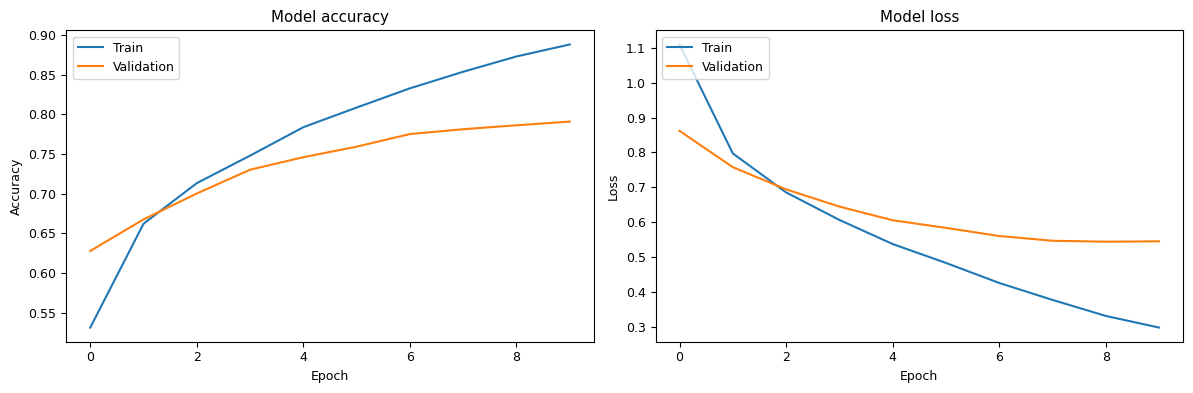

1487/1487 [==============================] - 1s 662us/step


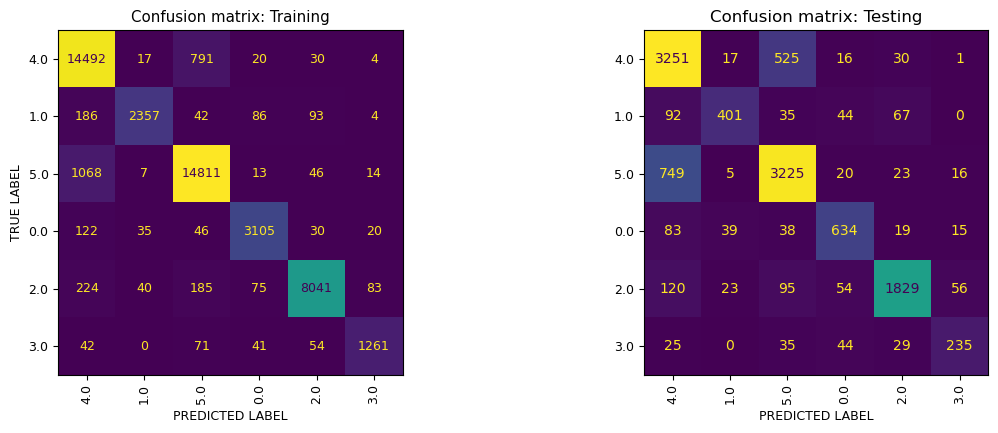

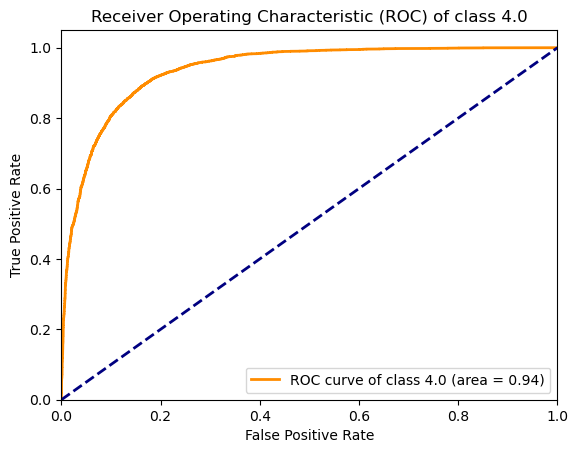

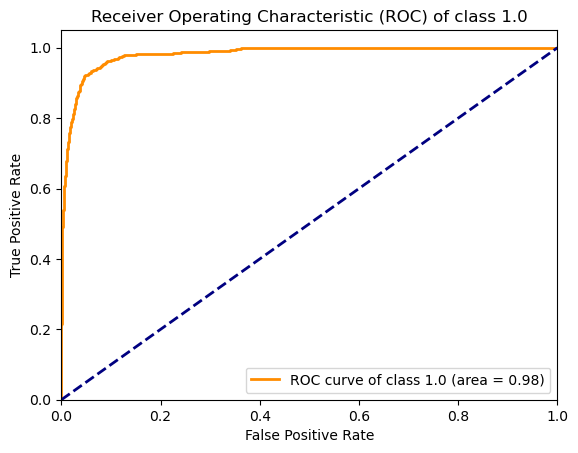

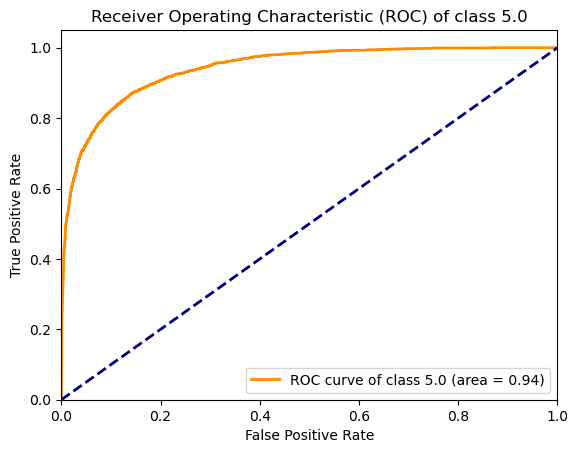

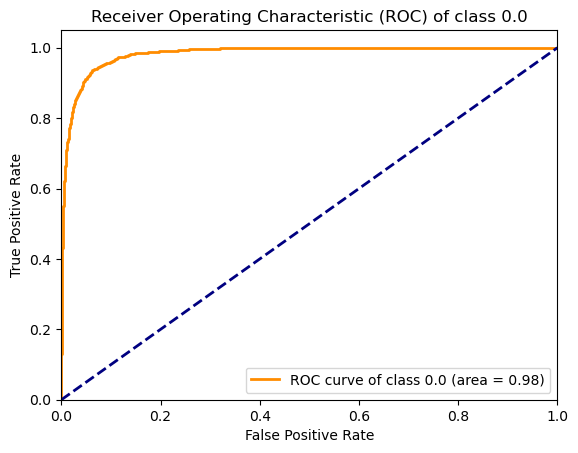

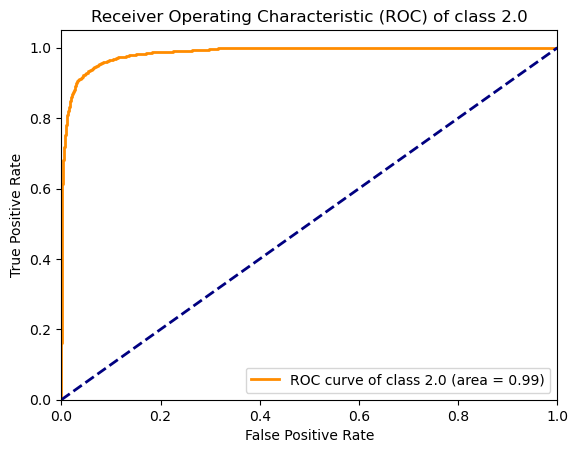

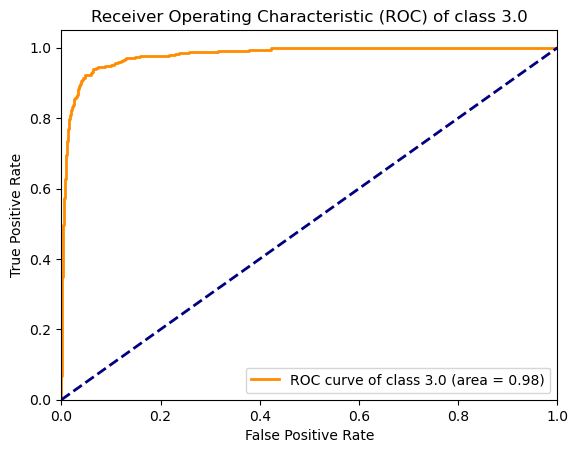

Accuracy: 0.8052985702270816
Confusion Matrix: 
[[3251   17  525   16   30    1]
 [  92  401   35   44   67    0]
 [ 749    5 3225   20   23   16]
 [  83   39   38  634   19   15]
 [ 120   23   95   54 1829   56]
 [  25    0   35   44   29  235]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      3840
           1       0.83      0.63      0.71       639
           2       0.82      0.80      0.81      4038
           3       0.78      0.77      0.77       828
           4       0.92      0.84      0.88      2177
           5       0.73      0.64      0.68       368

    accuracy                           0.81     11890
   macro avg       0.80      0.75      0.77     11890
weighted avg       0.81      0.81      0.81     11890

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean_reduced.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)


In [ ]:
# Use random forest classifier.
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Loading the entire dataset
data_full = pd.read_csv('clean.csv')

# Specifying the features and the target variable
features = [
    "rotationRate.x", "rotationRate.y", "rotationRate.z",
    "userAcceleration.x", "userAcceleration.y", "userAcceleration.z"
]
target = "act"

# Training the Random Forest classifier on the entire data
clf_full_data = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full_data.fit(data_full[features], data_full[target])

# Getting feature importances from the model trained on full data
feature_importances_full = clf_full_data.feature_importances_

# Sorting the features based on importance
sorted_idx = feature_importances_full.argsort()
features_sorted = [features[i] for i in sorted_idx]
importances_sorted = feature_importances_full[sorted_idx]

# Visualizing the sorted feature importances
plt.figure(figsize=(10, 6))
plt.bar(features_sorted, importances_sorted, color='dodgerblue')
plt.title('Sorted Feature Importances (Full Data)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2